In [ ]:
# Adapted from C:\Users\leroquan\Documents\python\alplakes-particle-tracking\notebooks\D3DtoMITgcm_cartesian.ipynb (Fazel)

In [1]:
import numpy as np
import xarray as xr
from os.path import join
from xmitgcm import open_mdsdataset as mitgcmds

# PT post-processing

In [2]:
gcm_directory = r"C:/Users/leroquan/Documents/python/alplakes-particle-tracking/D3DtoMITgcm/geneva/converted_vfield/"
gcm_start = "2008-03-01 00:00"
# gcm_start = "2021-06-10 00:00"
# mitgcm output filename root
gcm_out_root = "3Dsnaps"
# MITgcm time step in seconds
gcm_dt = 30.0
# grid geometry used in the MITgcm simulation
gcm_geometry = "cartesian"

# create a "lake_arr" to just show the lake area. A better alternative is lake shoreline file (to be improved)
data = mitgcmds(gcm_directory, delta_t=gcm_dt, ref_date=gcm_start,
                 geometry=gcm_geometry, read_grid=False,
                 prefix=[gcm_out_root])
grid = mitgcmds(gcm_directory, delta_t=gcm_dt, ref_date=gcm_start,
                 geometry=gcm_geometry, read_grid=True,
                 prefix=[gcm_out_root], iters=[], swap_dims=False,endian='<')
lake_arr = np.array(grid.Depth)
lake_arr[lake_arr <= 0] = np.nan
lake_arr[lake_arr > 0] = 1

C:\Users\leroquan\AppData\Local\anaconda3\envs\mitgcm_env\lib\site-packages\xmitgcm\mds_store.py:913: UserWarning: Couldn't find available_diagnostics.log in C:/Users/leroquan/Documents/python/alplakes-particle-tracking/D3DtoMITgcm/geneva/converted_vfield/ or C:/Users/leroquan/Documents/python/alplakes-particle-tracking/D3DtoMITgcm/geneva/converted_vfield/. Using default version.
  warnings.warn("Couldn't find available_diagnostics.log "
C:\Users\leroquan\AppData\Local\anaconda3\envs\mitgcm_env\lib\site-packages\xmitgcm\mds_store.py:913: UserWarning: Couldn't find available_diagnostics.log in C:/Users/leroquan/Documents/python/alplakes-particle-tracking/D3DtoMITgcm/geneva/converted_vfield/ or C:/Users/leroquan/Documents/python/alplakes-particle-tracking/D3DtoMITgcm/geneva/converted_vfield/. Using default version.
  warnings.warn("Couldn't find available_diagnostics.log "
C:\Users\leroquan\AppData\Local\anaconda3\envs\mitgcm_env\lib\site-packages\xmitgcm\mds_store.py:913: UserWarning: C

In [4]:
# read PT outputs

data_dir = r"C:/Users/leroquan/Documents/python/alplakes-particle-tracking/D3DtoMITgcm/geneva/PT_test/"
fname = "results"
data_file = join(data_dir, "%s_run.nc" % fname)
inout_file = join(data_dir, "%s_inout.nc" % fname)
# open without chunks otherwise loading takes forever
data = xr.open_dataset(data_file, decode_times=True)
inout = xr.open_dataset(inout_file, decode_times=True)

In [73]:
# read all the grid- and time-related outputs
time_plt = data.time
xG = data.XG_p1
yG = data.YG_p1
xC = data.XC
yC = data.YC
bathy = data.Depth.to_masked_array()

gridAngle = np.arctan2(Y1-Y0, X1-X0) # convert MITgcm outputs to the real grid
# x_com = np.array(xG[0, :])
# y_com = np.array(yG[:, 0])
# xx_com,yy_com = np.meshgrid(x_com,y_com)
xx_com = np.array(xG.data)
yy_com = np.array(yG.data)

xG_conv = (np.cos(gridAngle)*xx_com - np.sin(gridAngle)*yy_com) + X0
yG_conv = (np.sin(gridAngle)*xx_com + np.cos(gridAngle)*yy_com) + Y0

In [74]:
# realease depth which will be plotted
z0_ini = [0,30]
zdata = []
sel_pid = inout.pid.where((inout.z_ini>z0_ini[0]) & (inout.z_ini<=z0_ini[1]), drop=True)
zd = data.sel(pid=sel_pid, drop=True)
zd.xtrack.load()
zd.ytrack.load()
zd.ztrack.load()
zdata.append(zd)

In [75]:
# create the grid for spatiotemporal plots

xg_plt = xG.to_masked_array().filled()
yg_plt = yG.to_masked_array().filled()
font_feature = ['sans-serif', 16, 14] # [fontname, fontsize_labels, fontsize_ticks]
gridAngle = np.arctan2(Y1-Y0, X1-X0)
xp_conv = (np.cos(gridAngle)*xg_plt - np.sin(gridAngle)*yg_plt) + X0
yp_conv = (np.sin(gridAngle)*xg_plt + np.cos(gridAngle)*yg_plt) + Y0

xp_conv *= 1.e-3
yp_conv *= 1.e-3

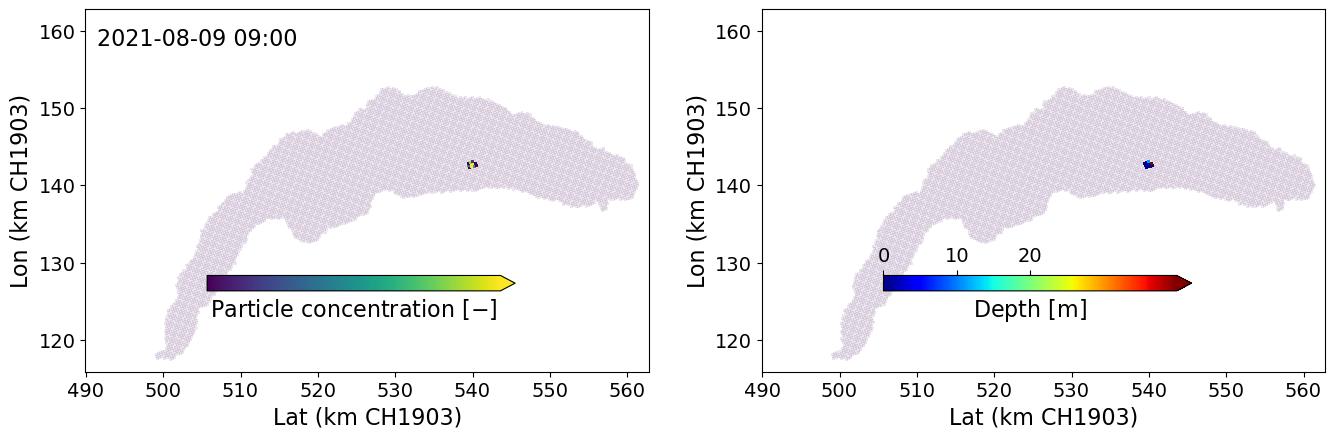

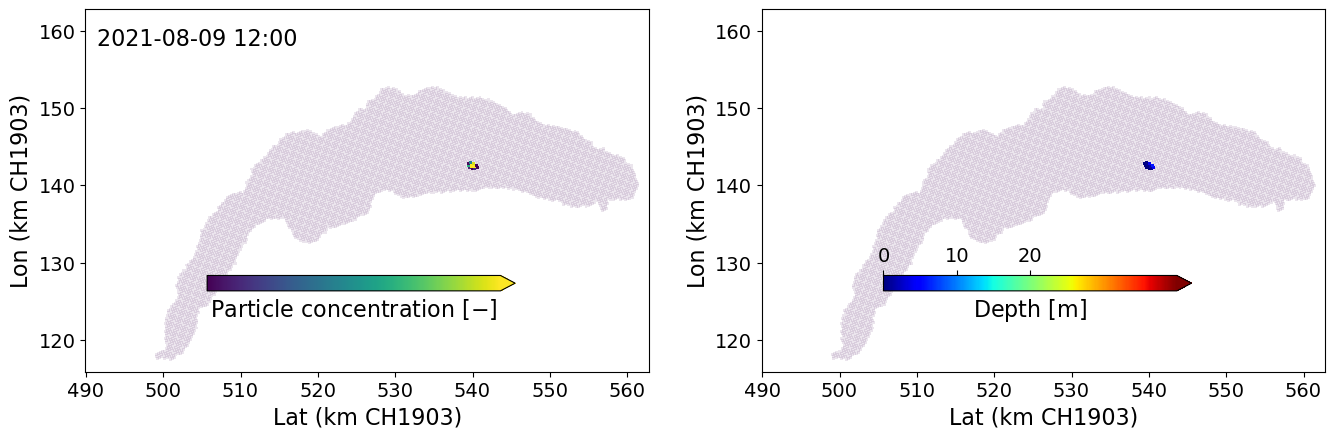

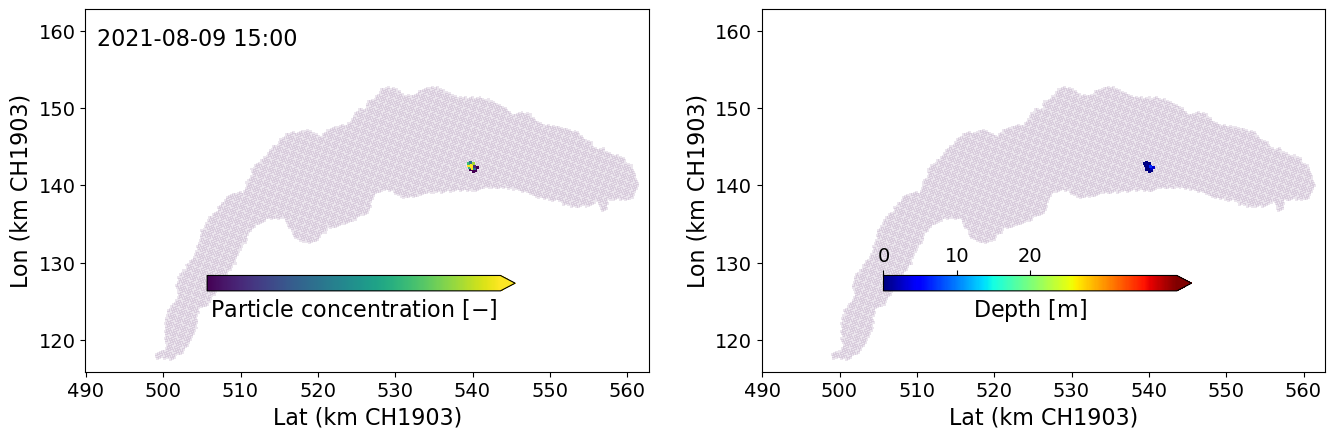

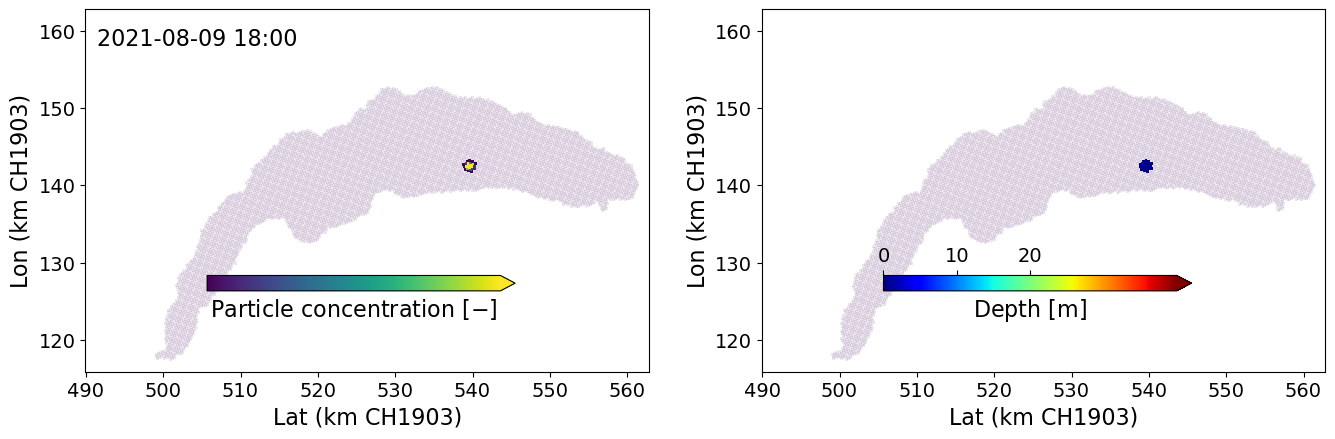

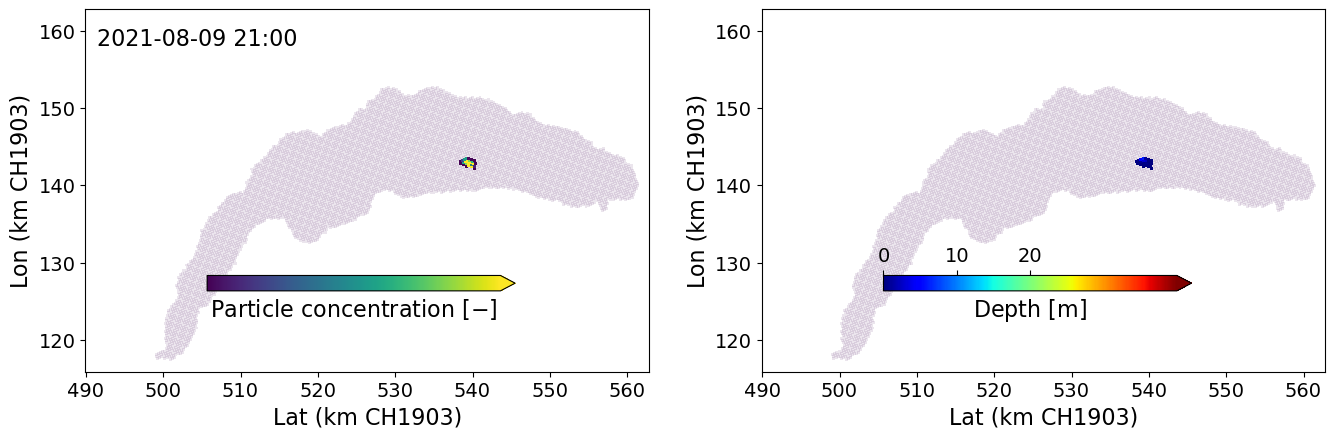

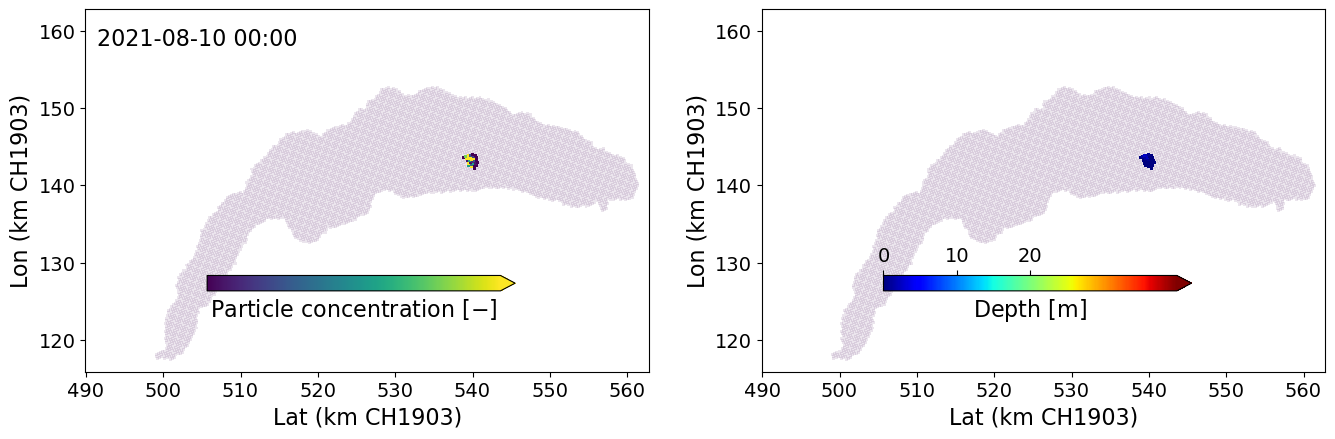

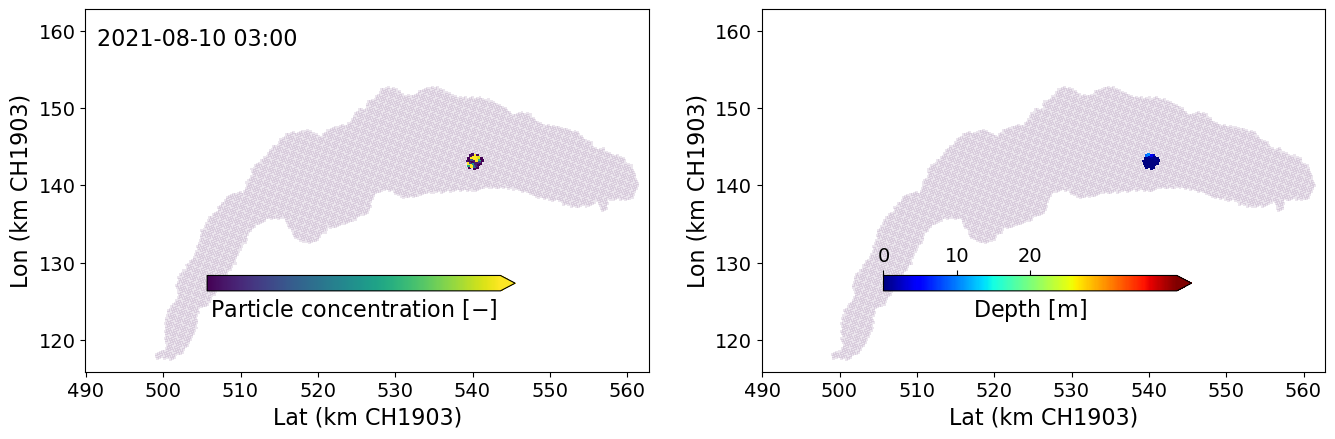

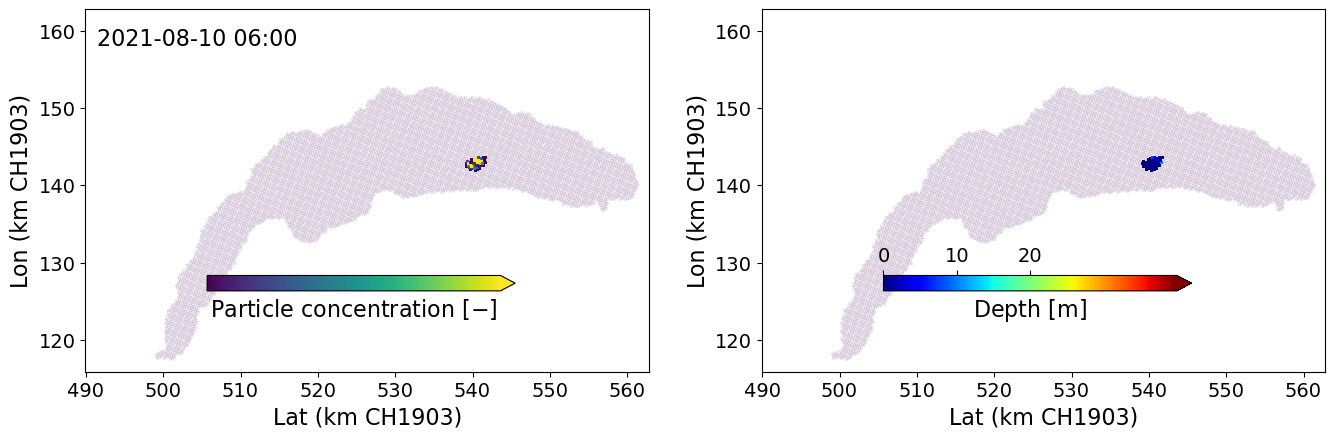

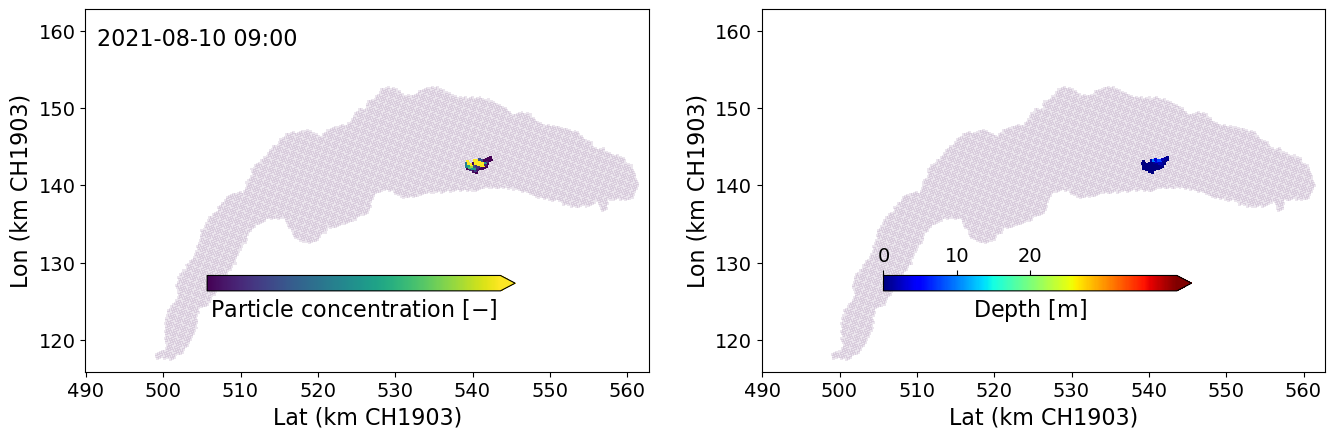

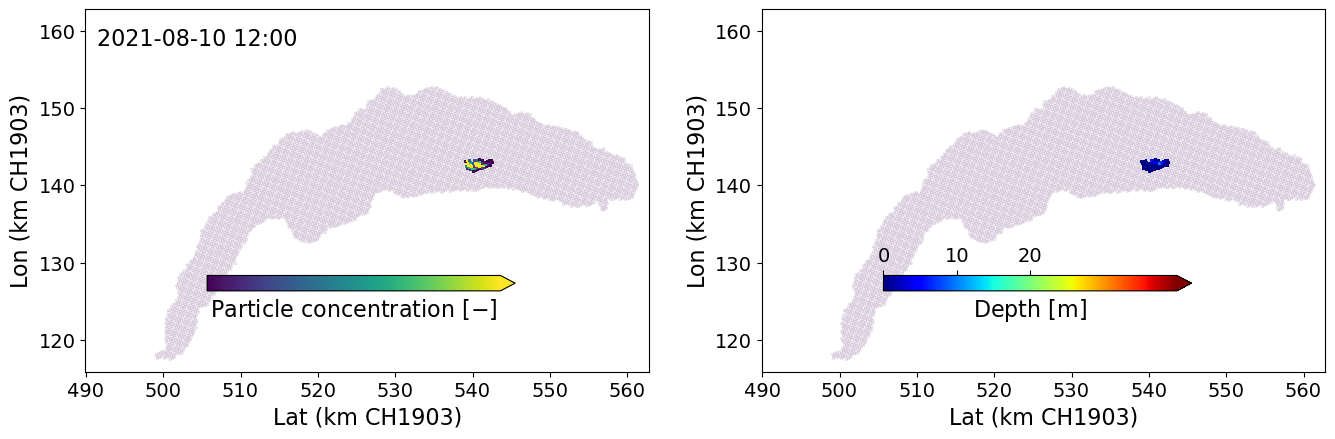

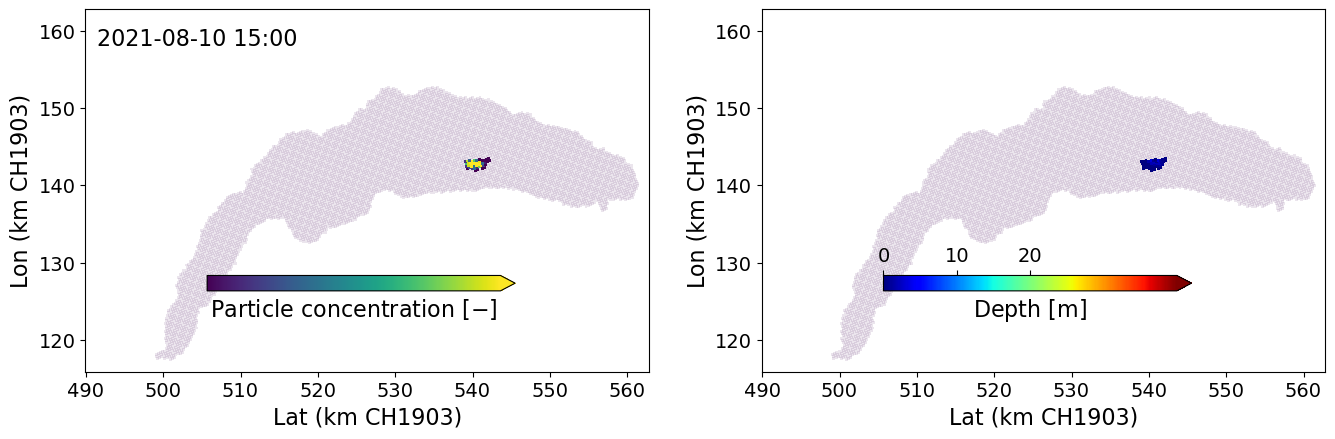

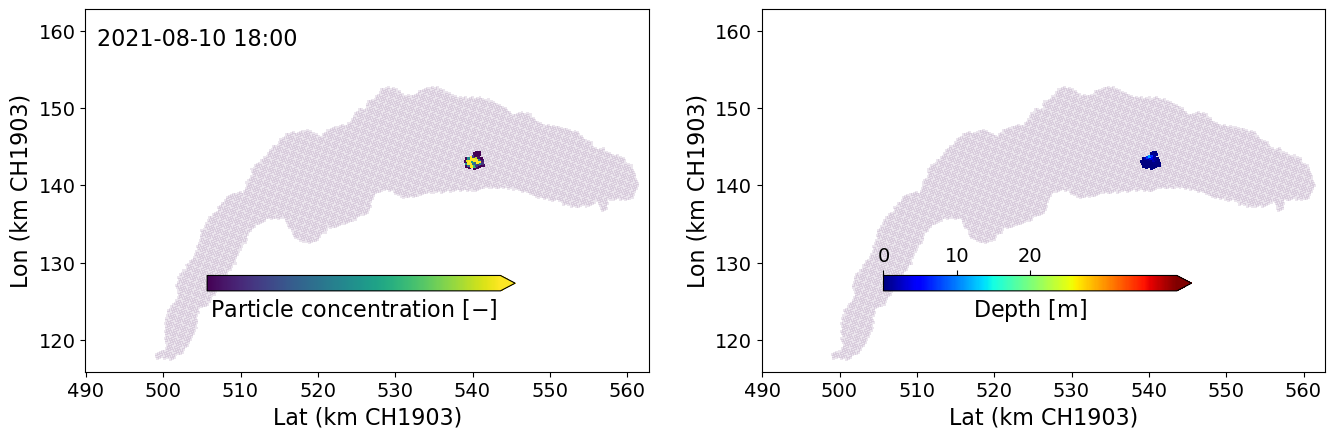

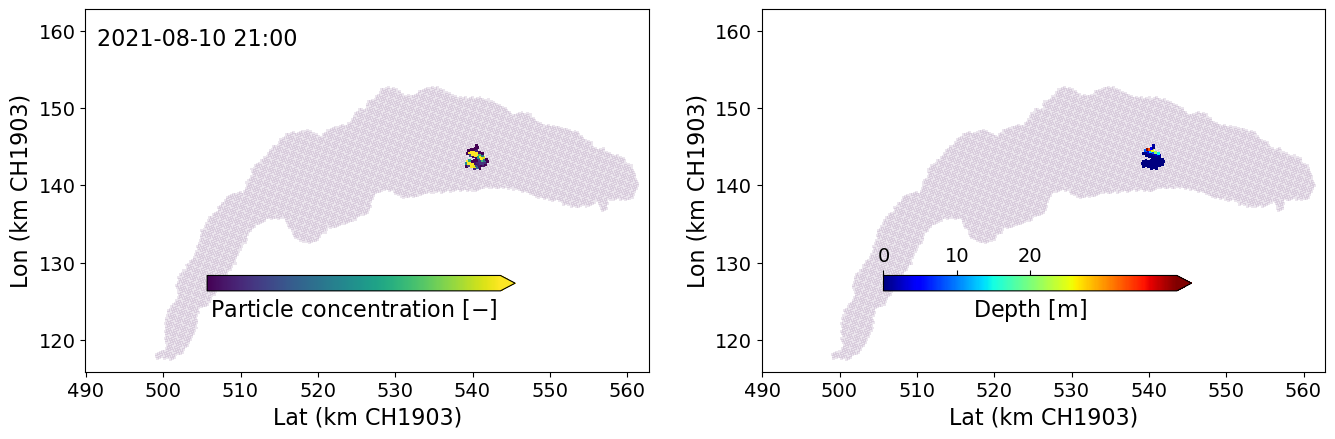

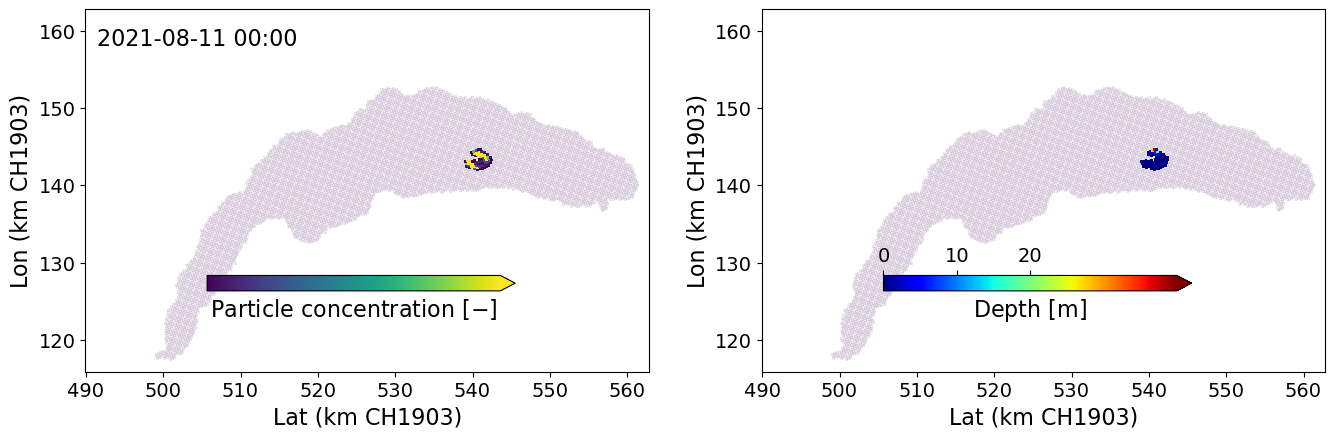

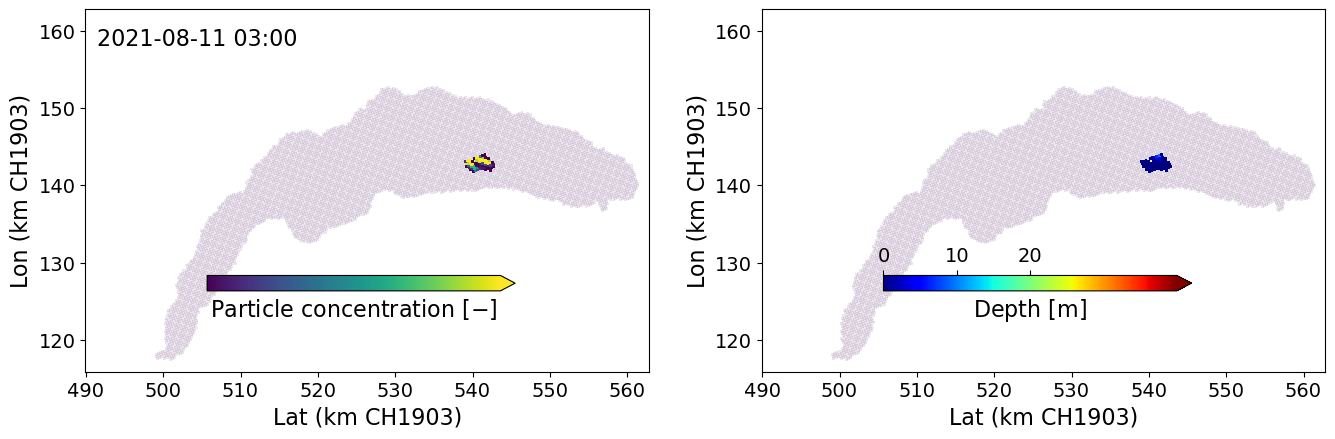

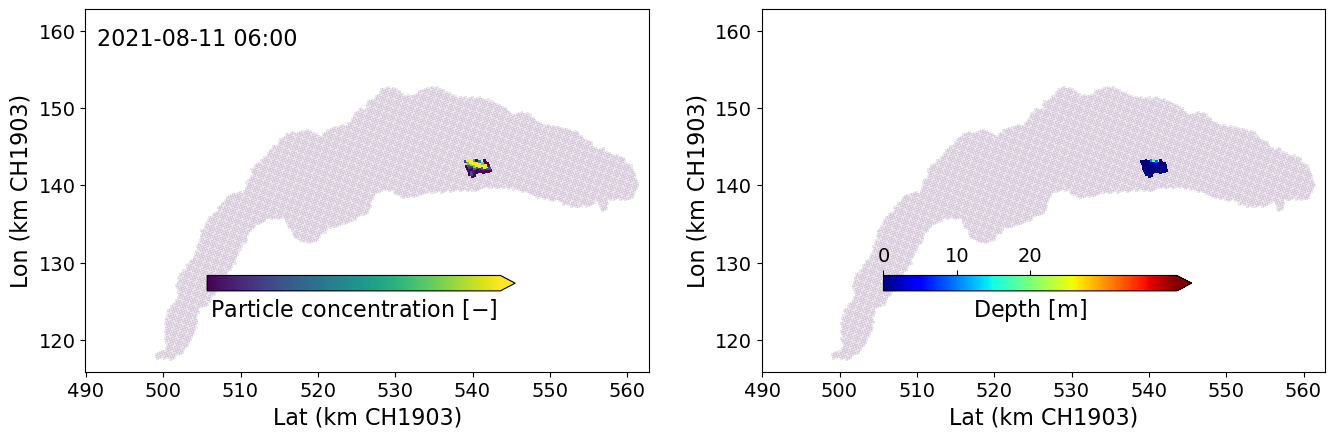

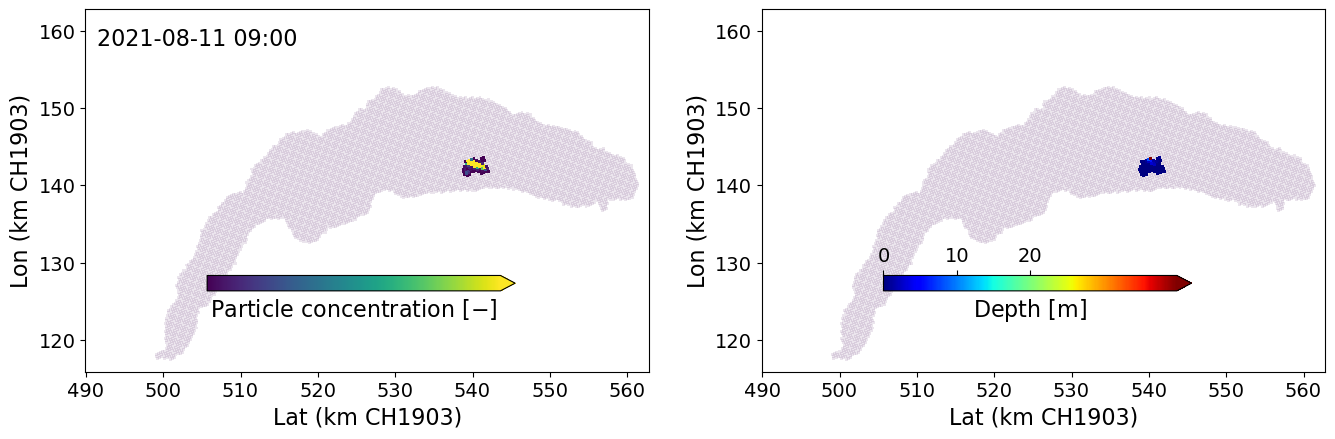

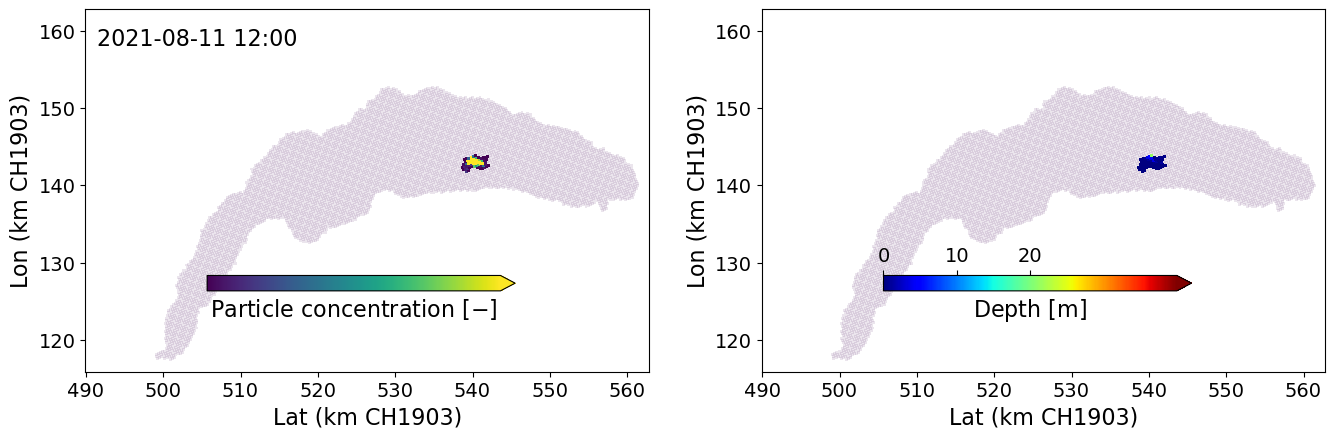

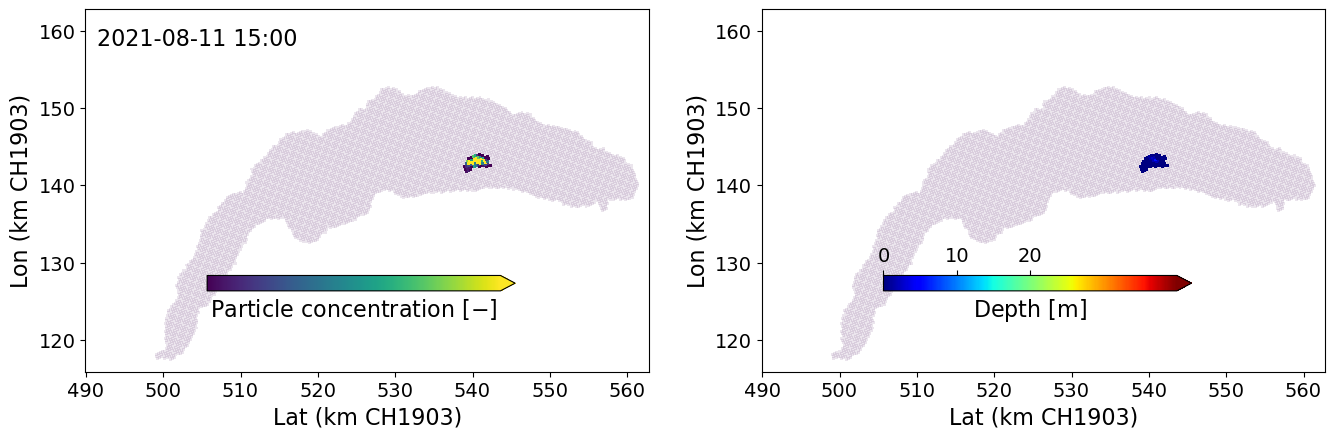

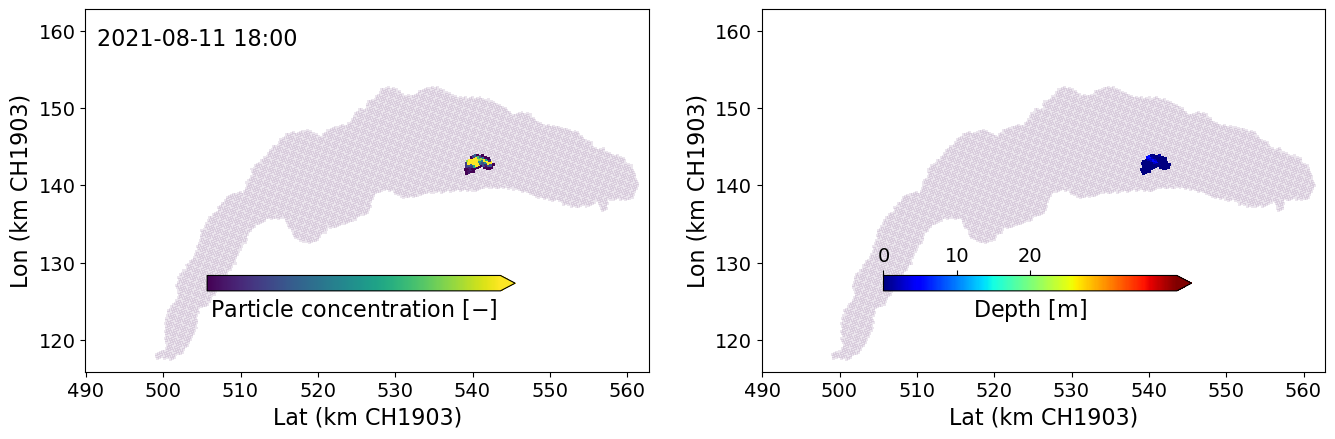

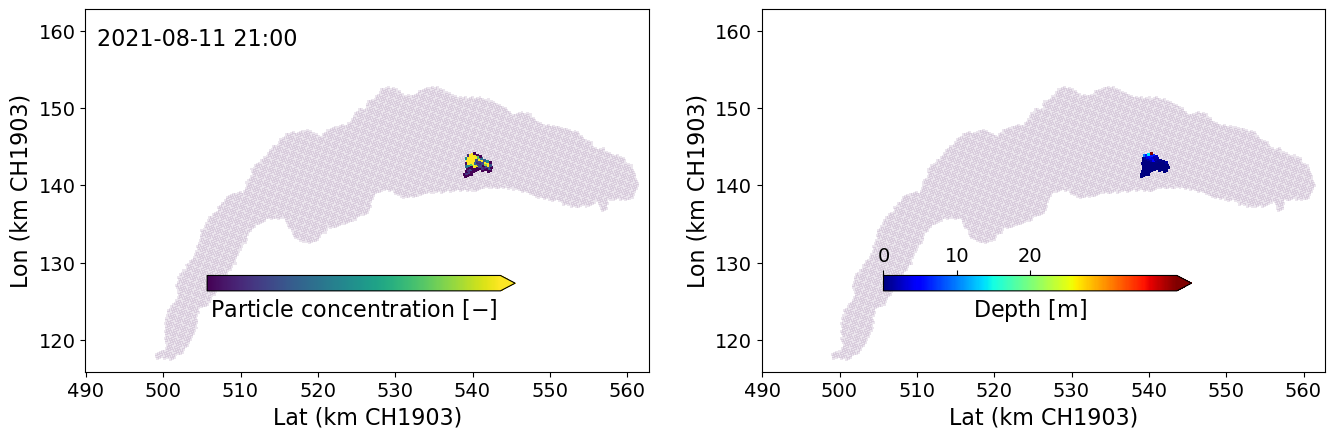

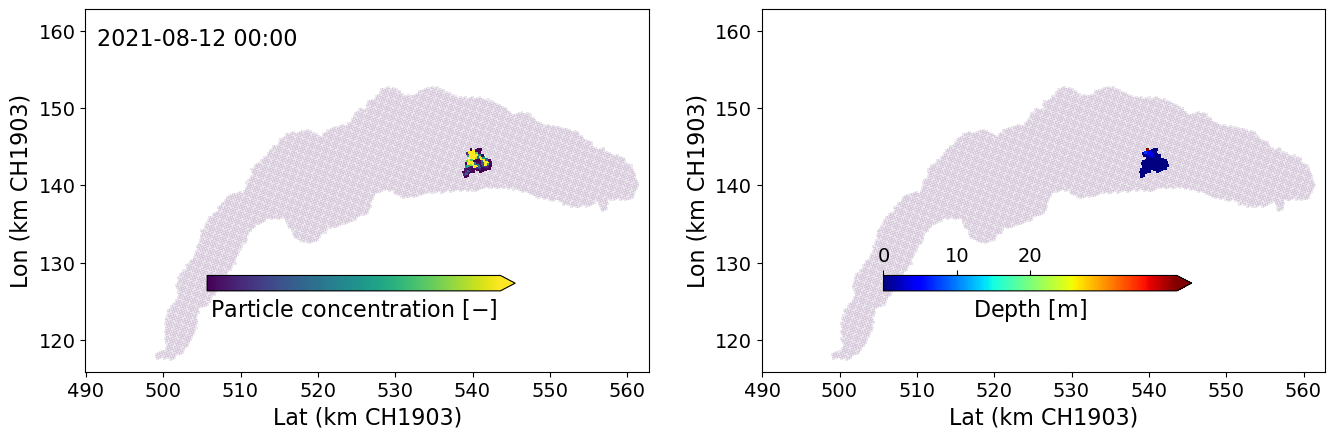

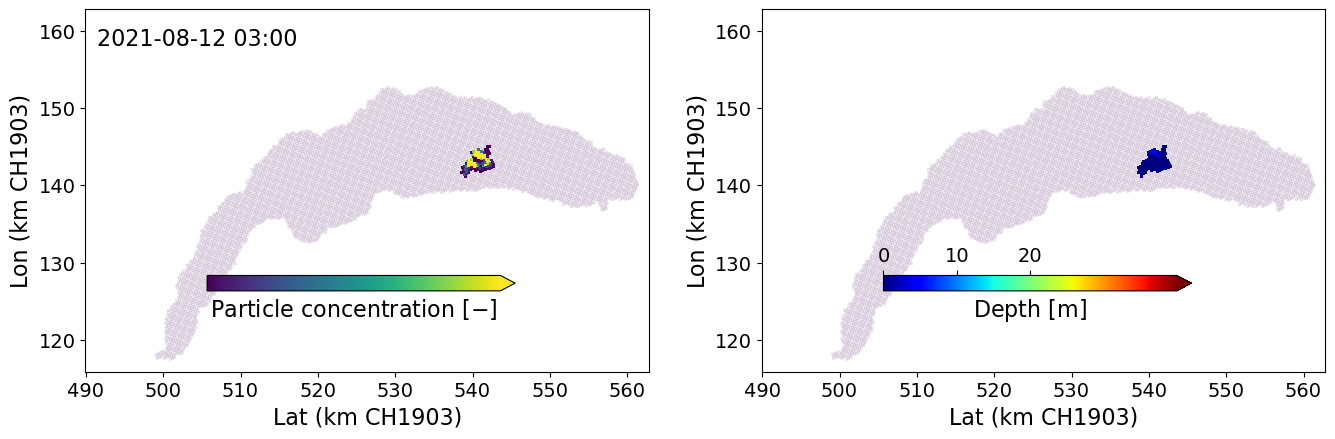

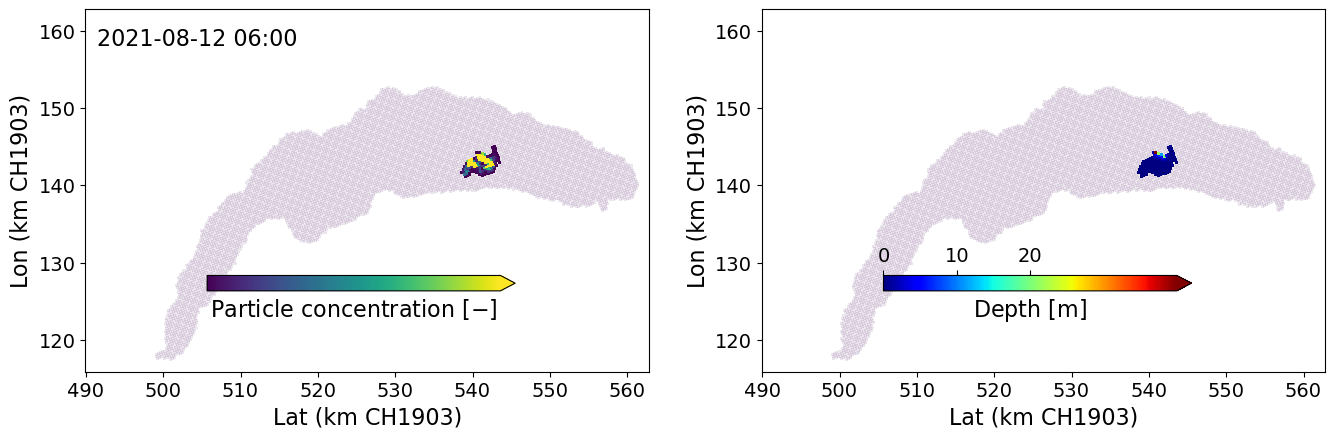

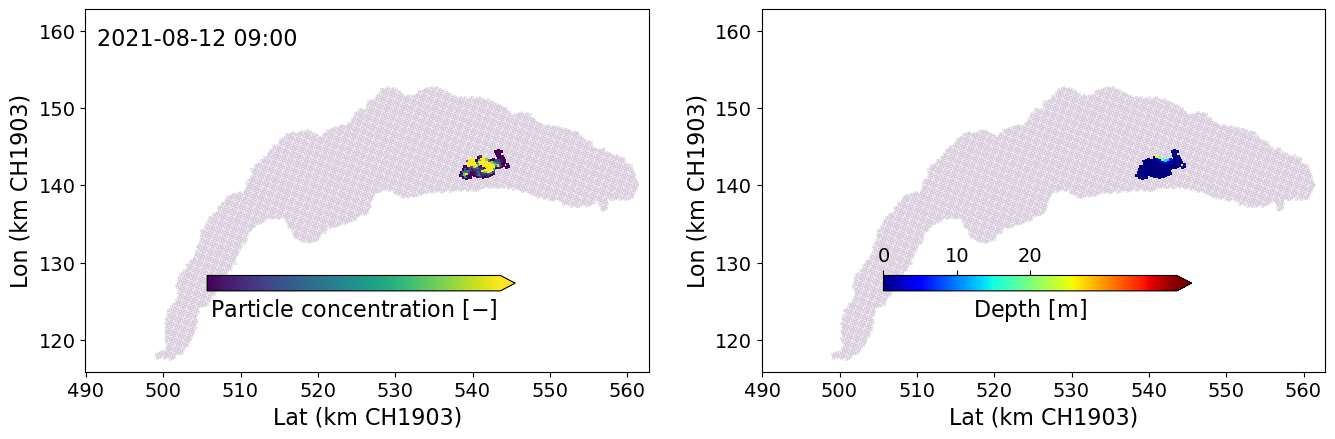

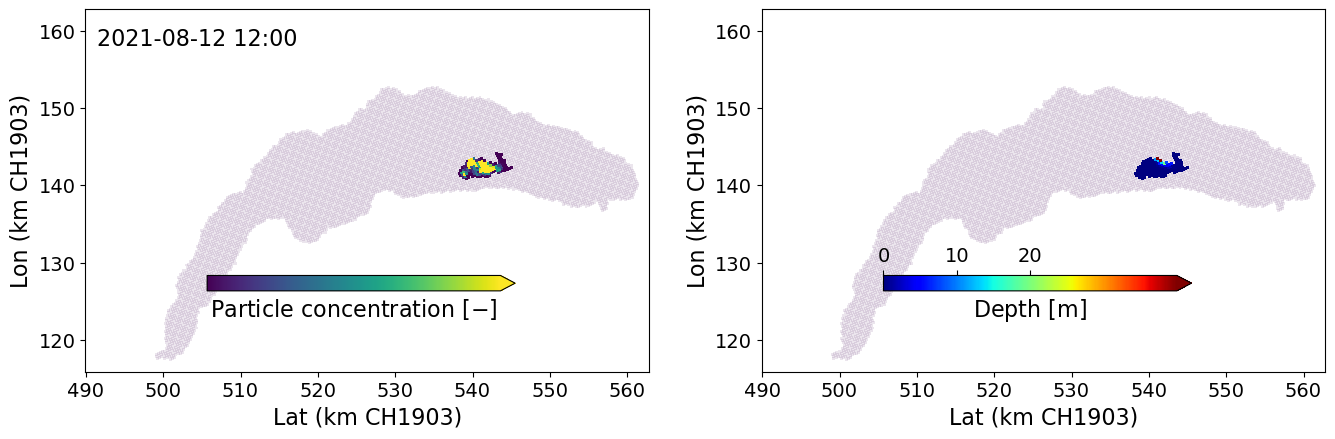

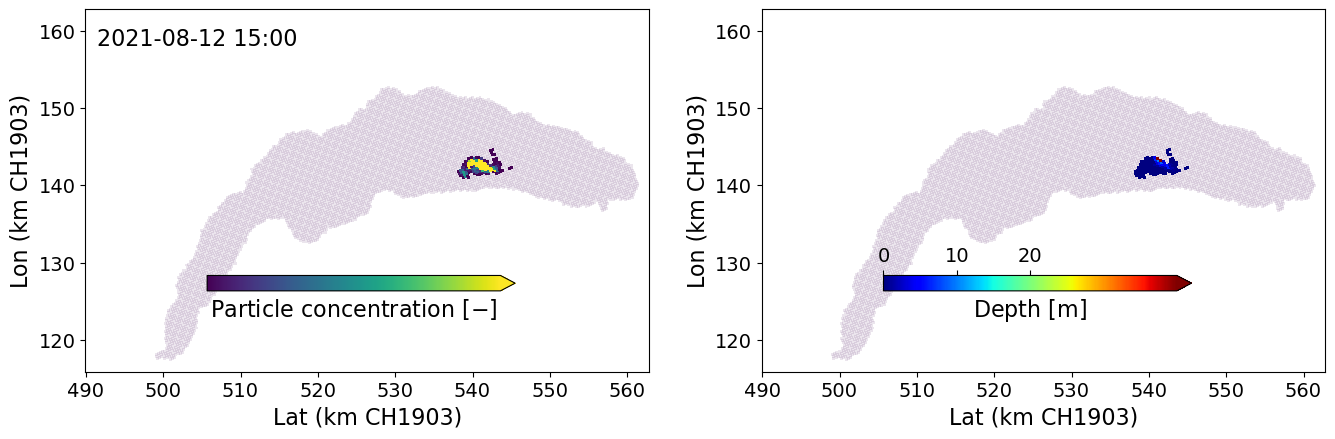

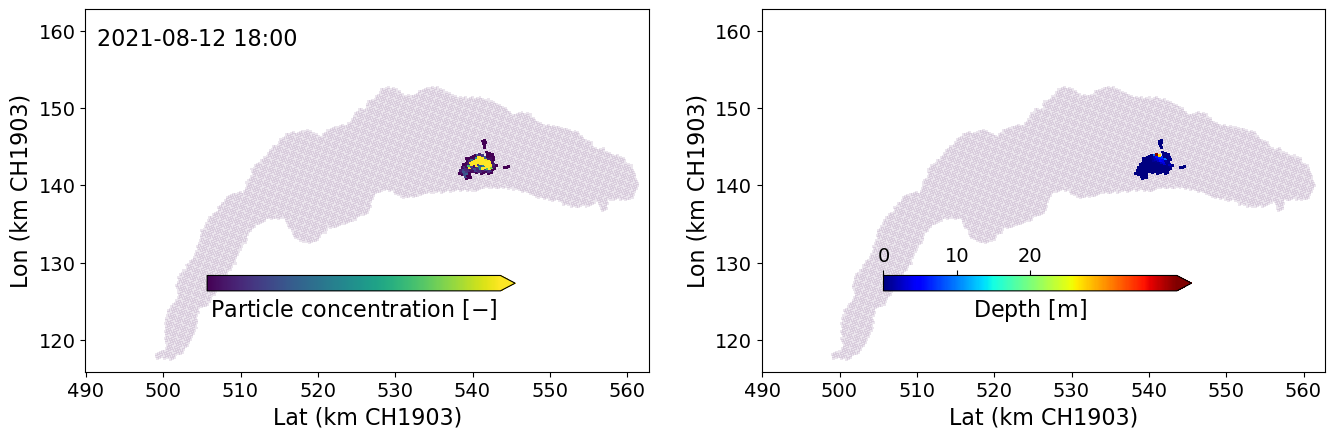

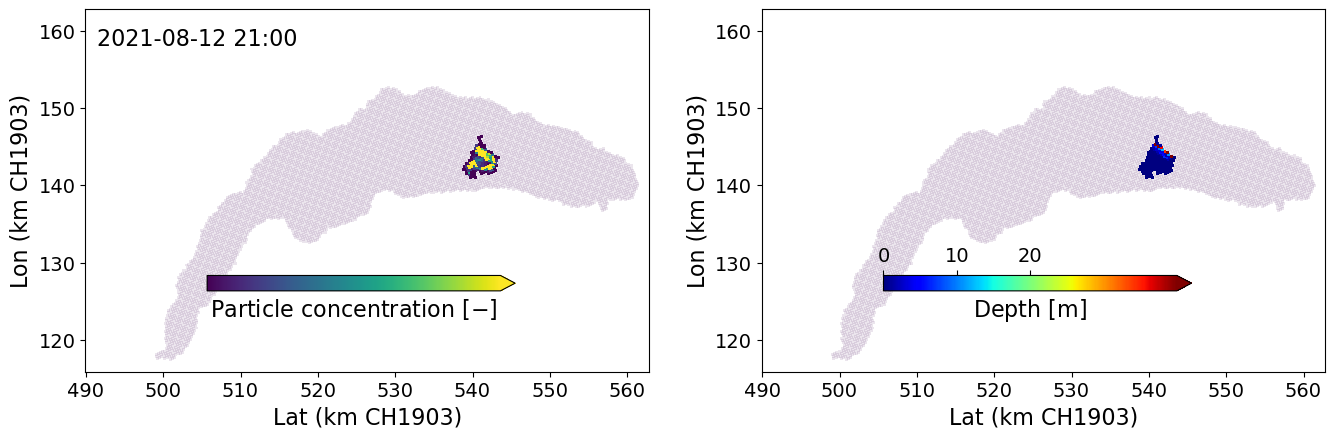

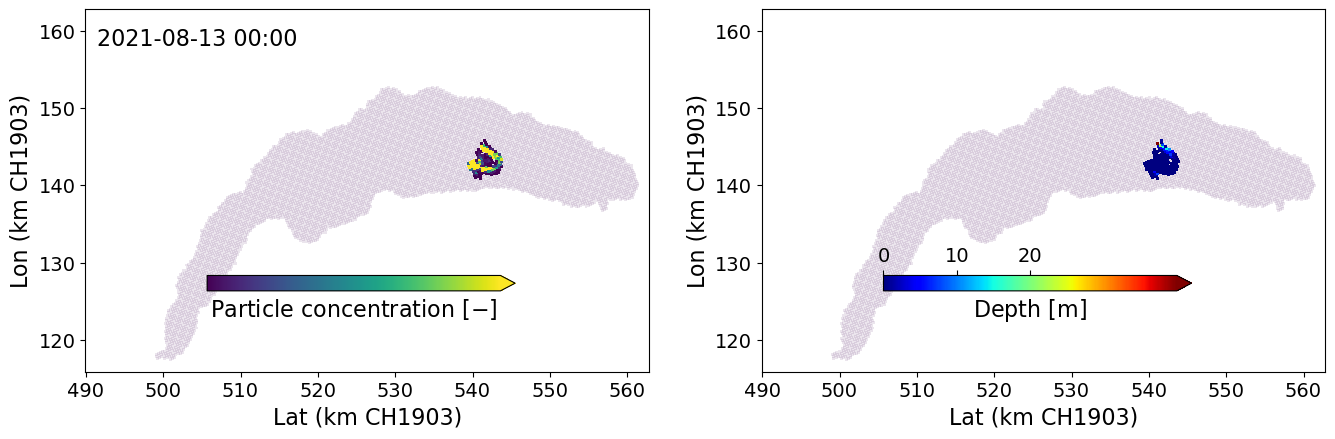

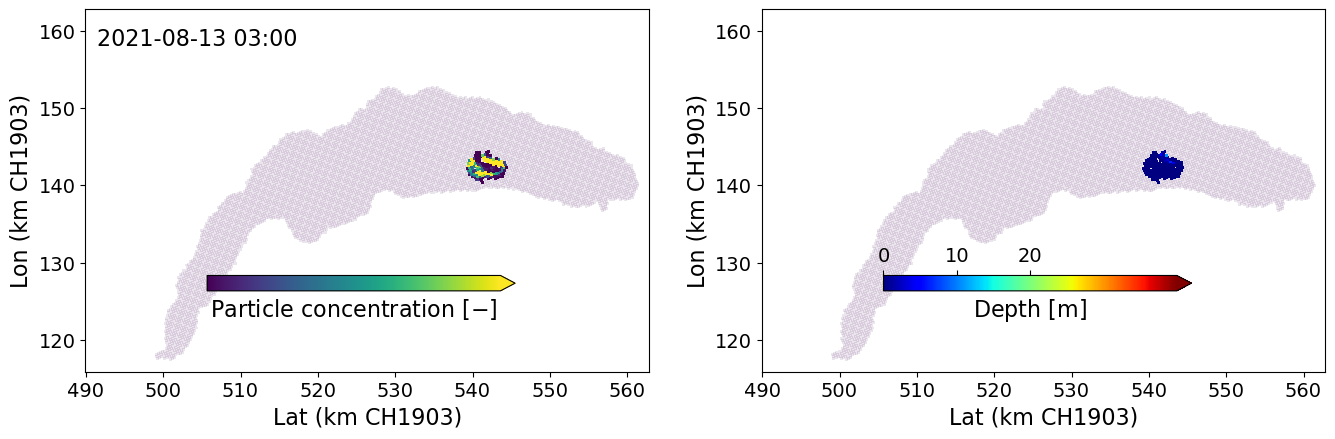

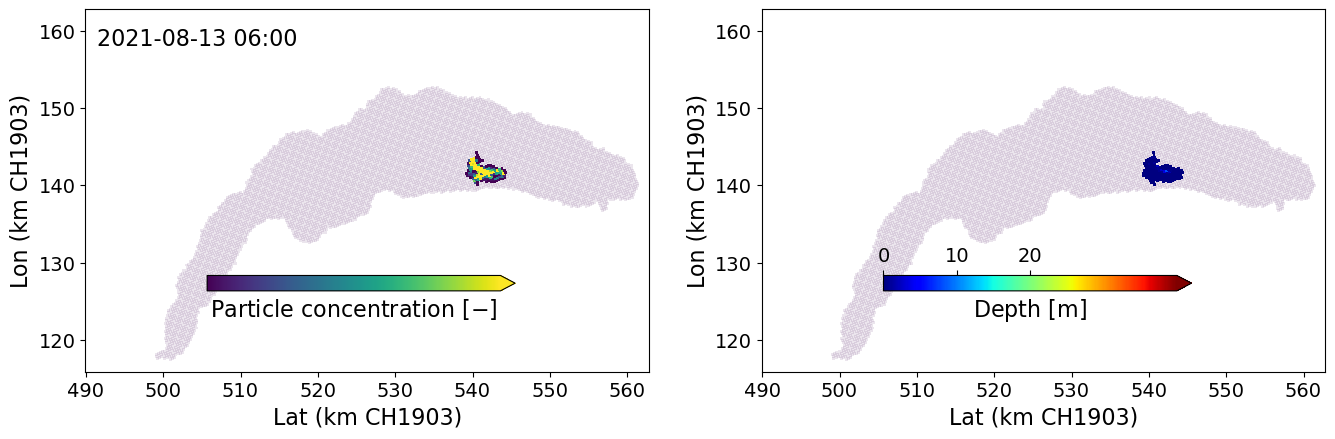

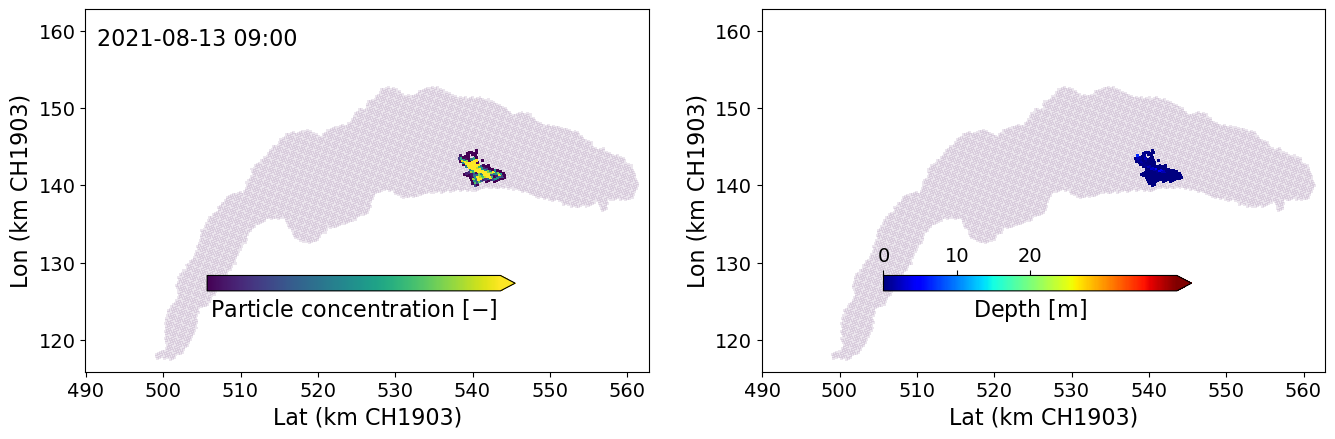

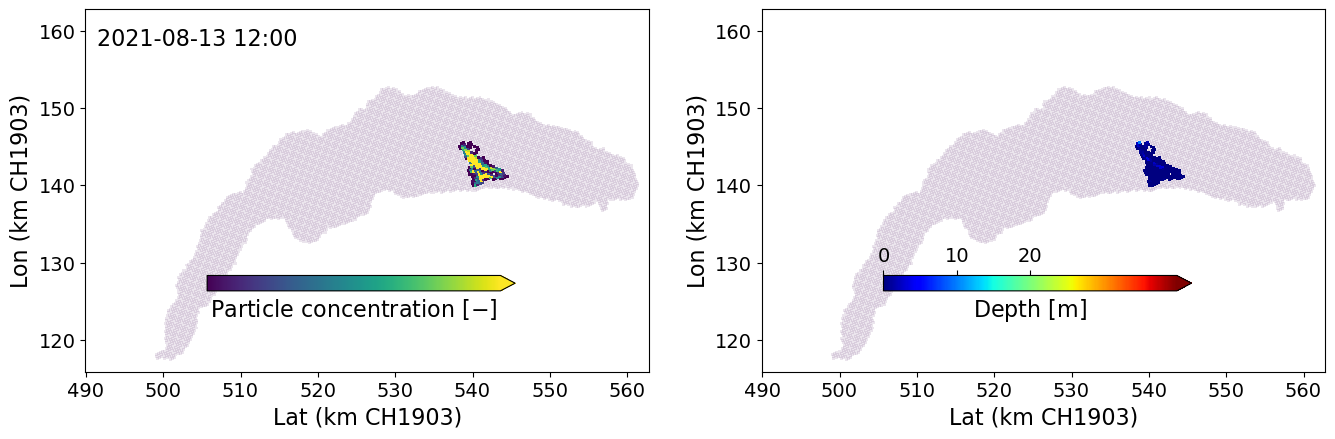

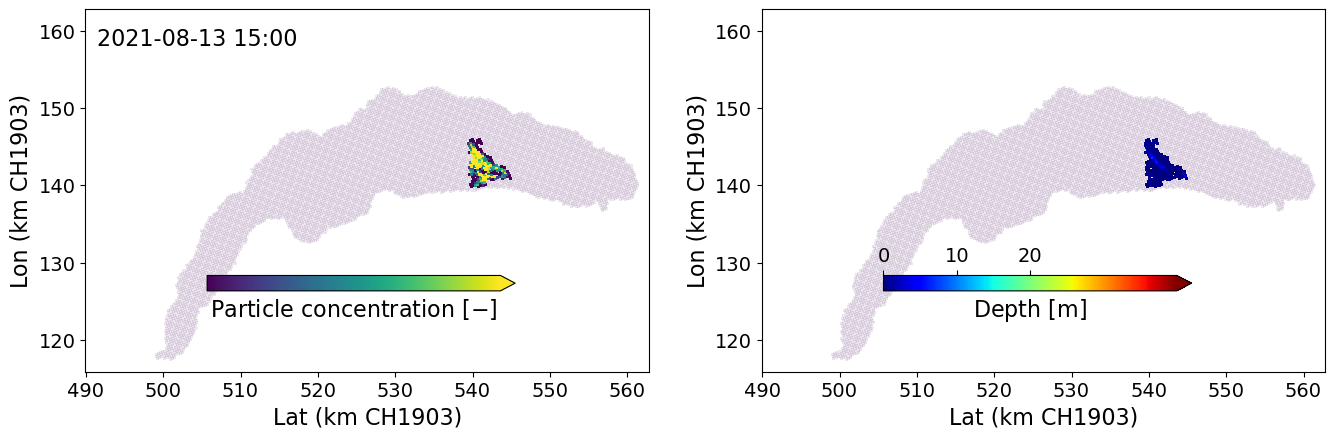

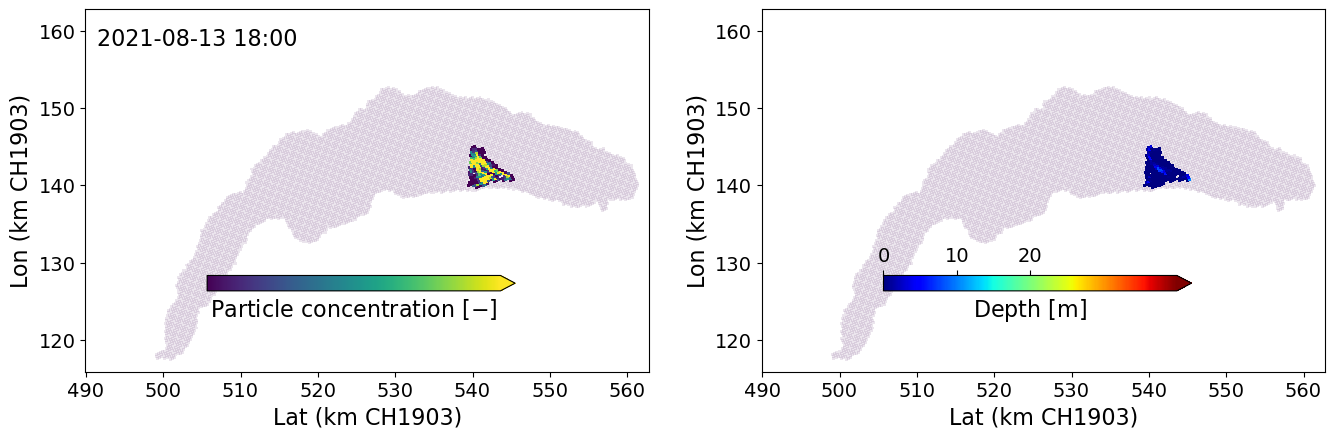

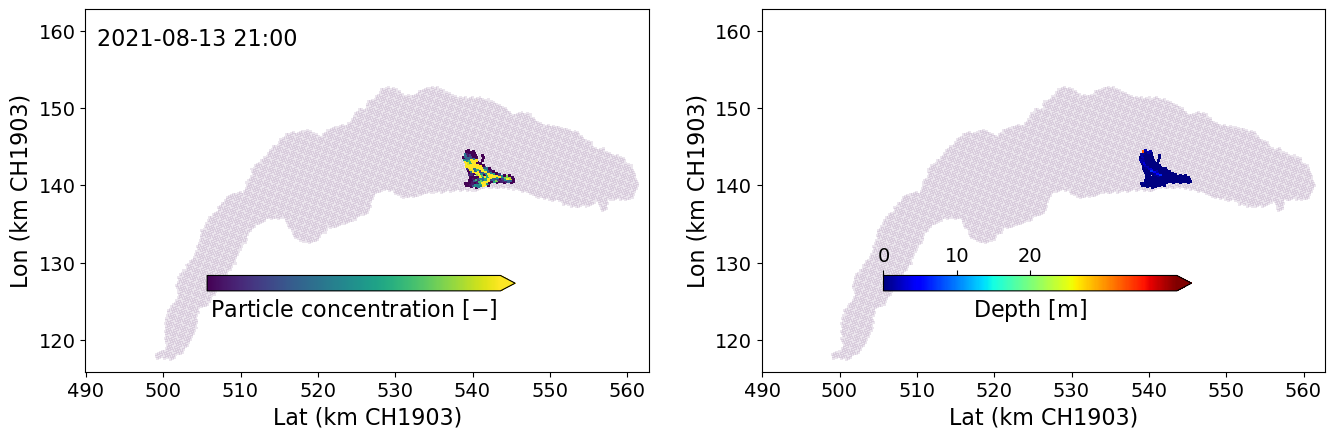

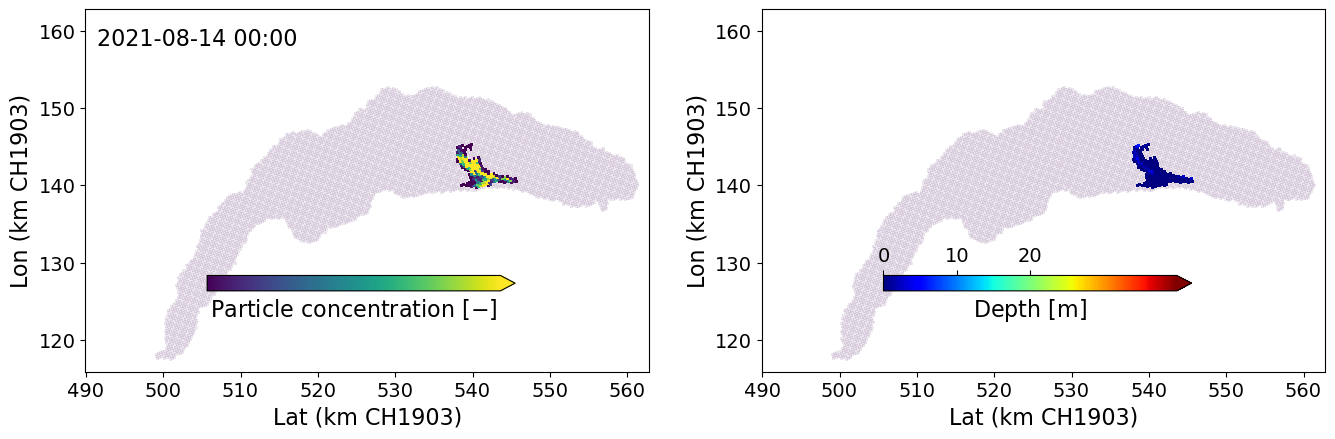

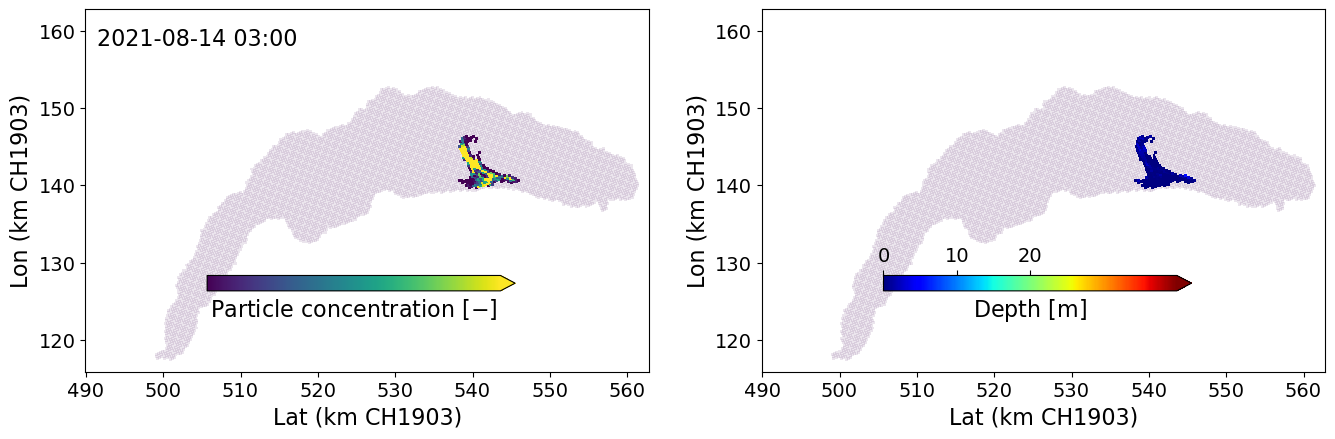

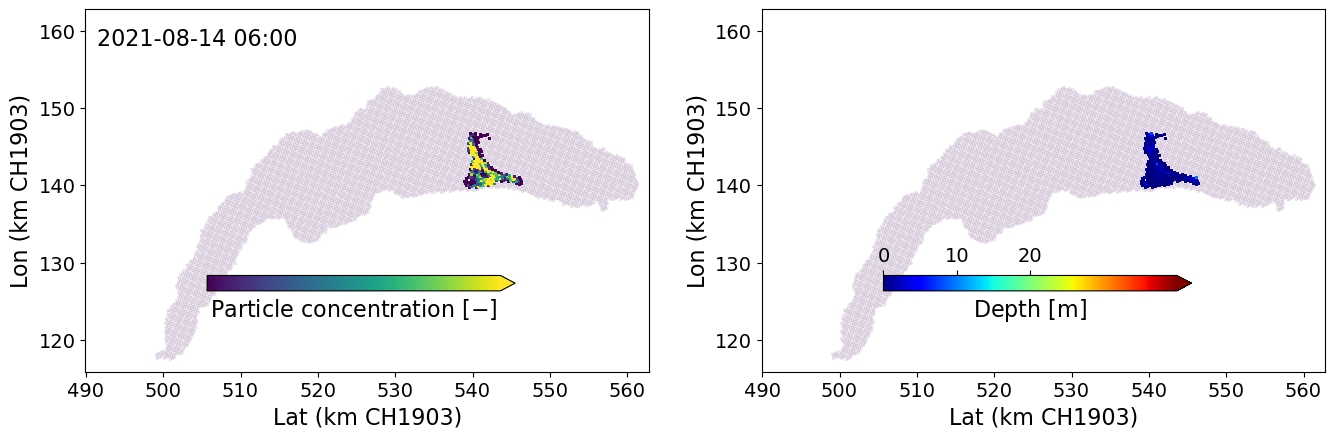

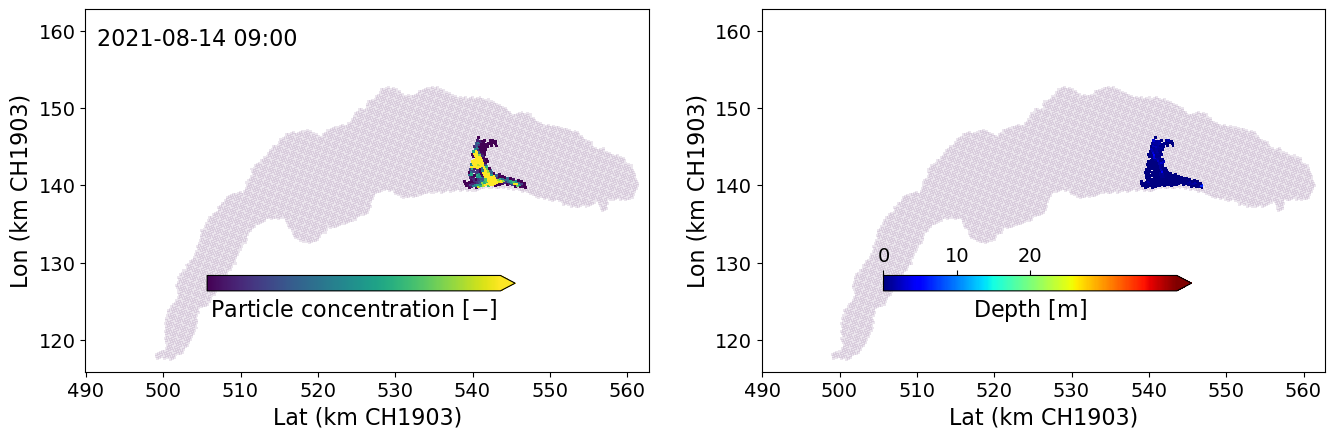

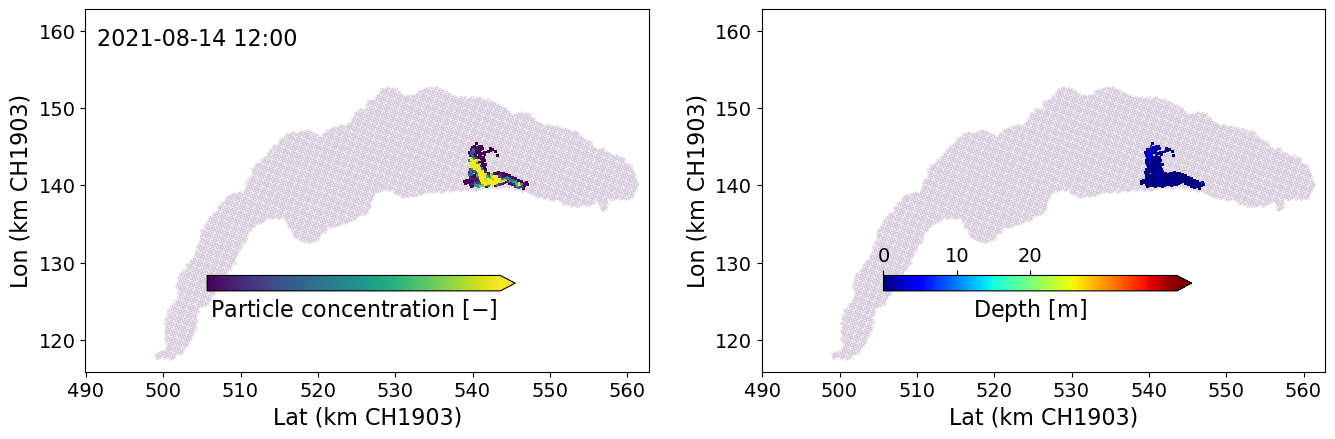

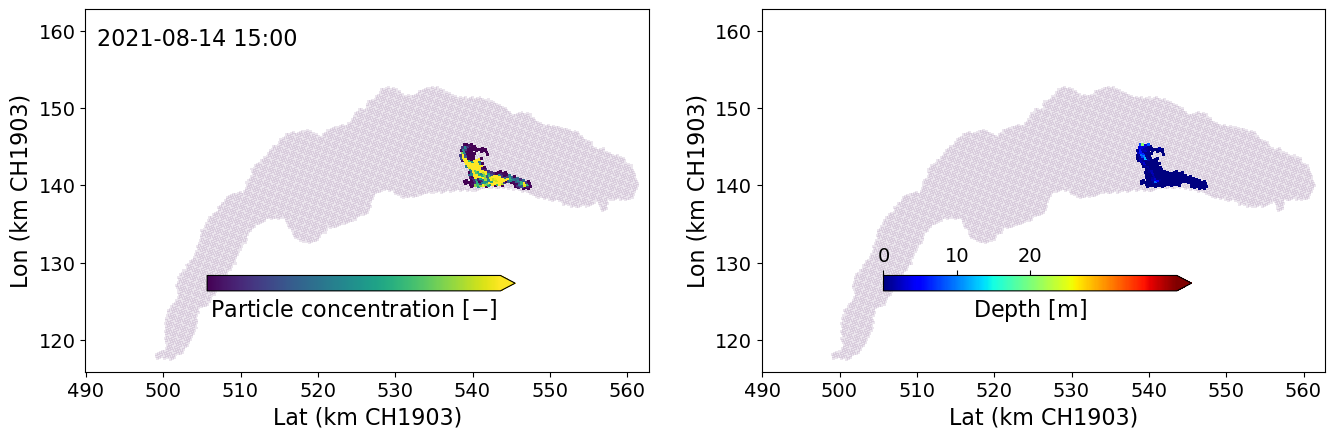

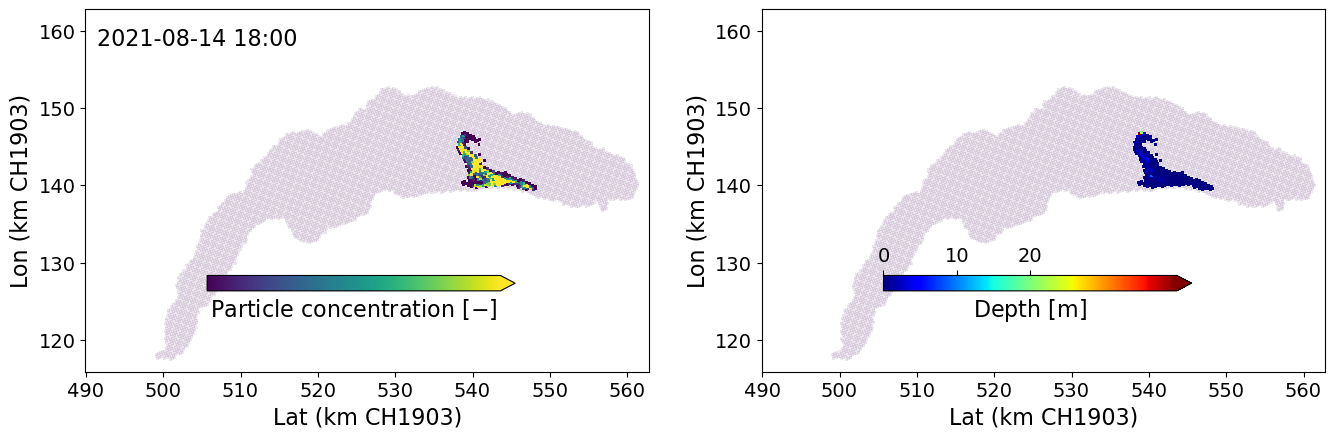

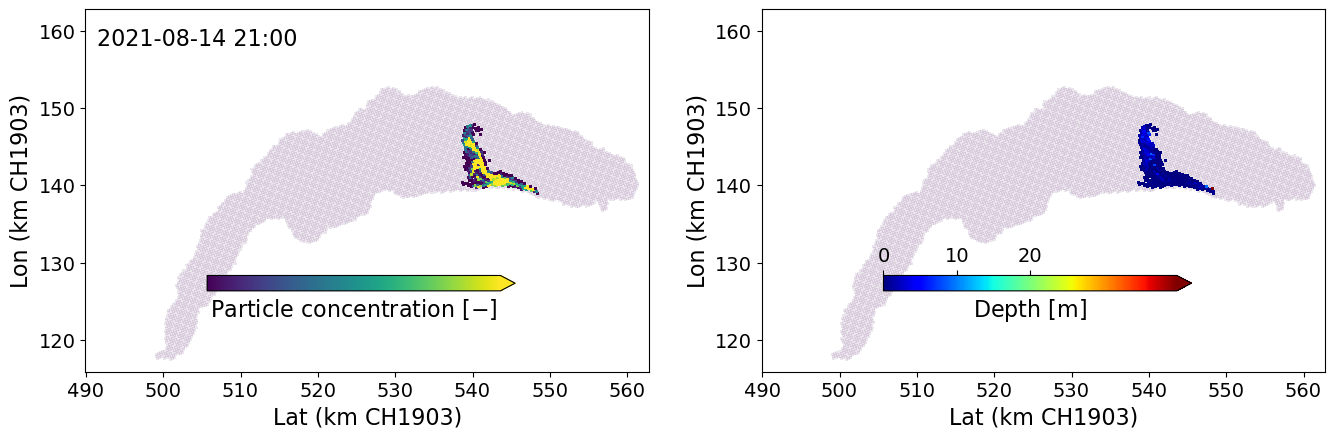

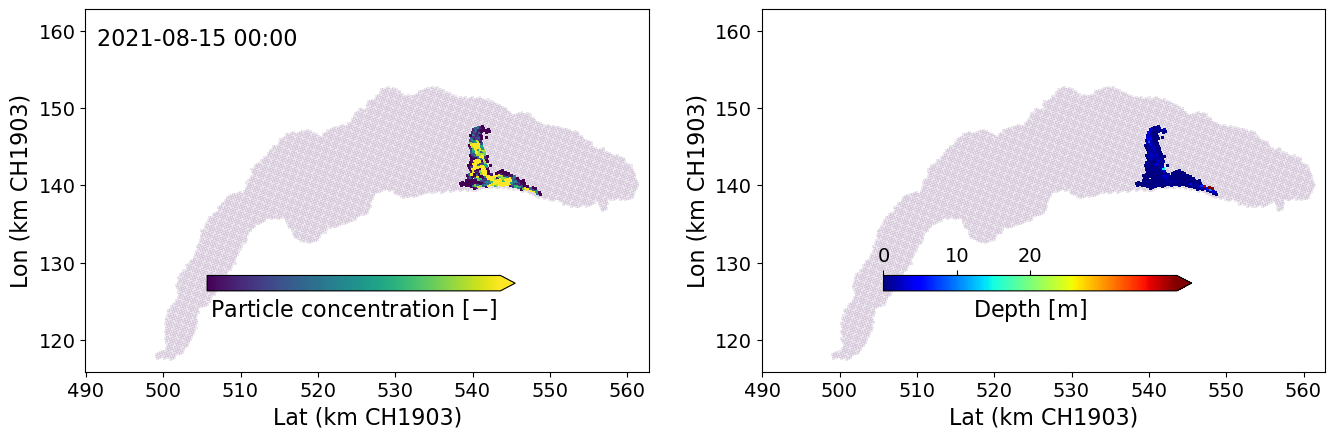

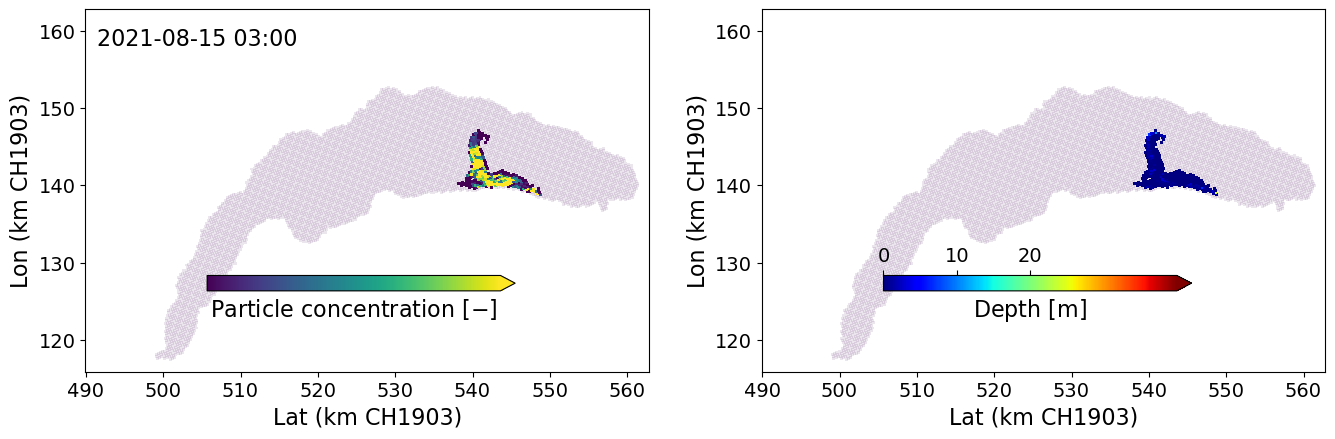

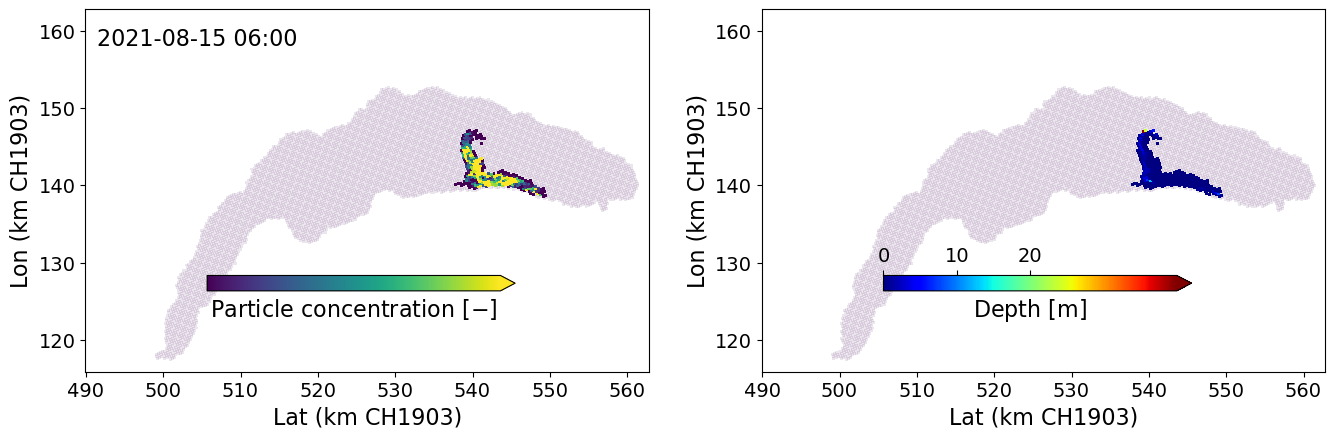

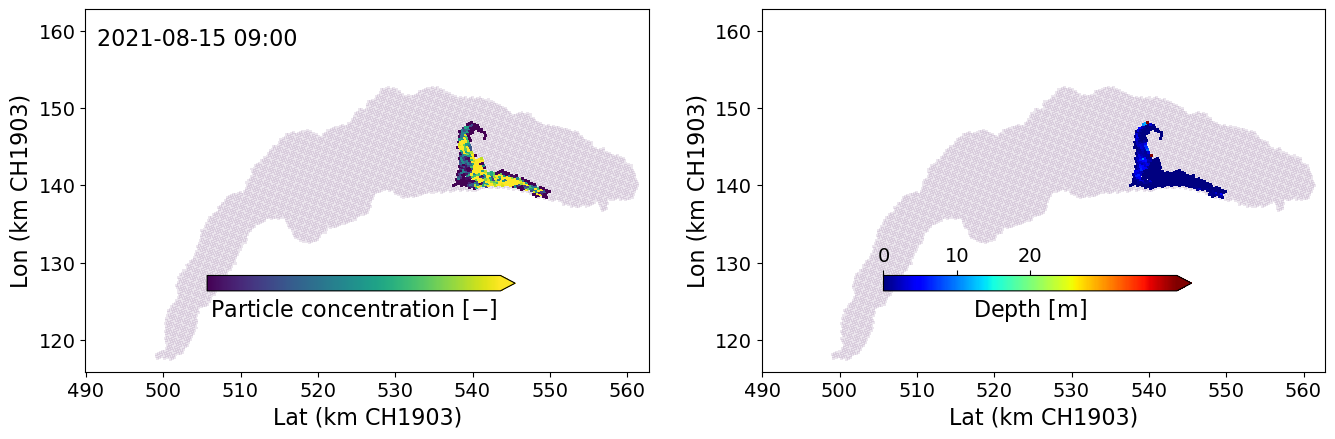

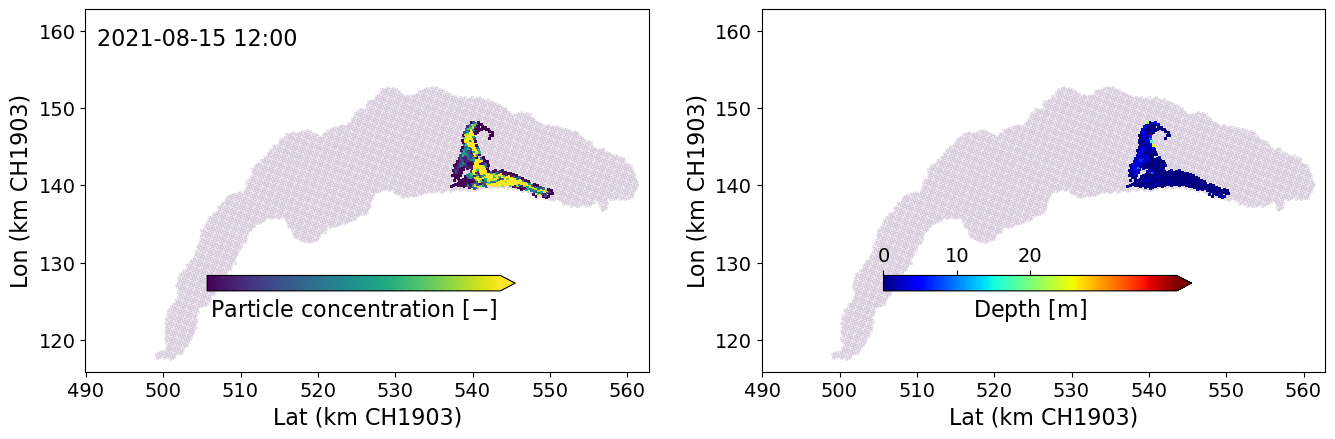

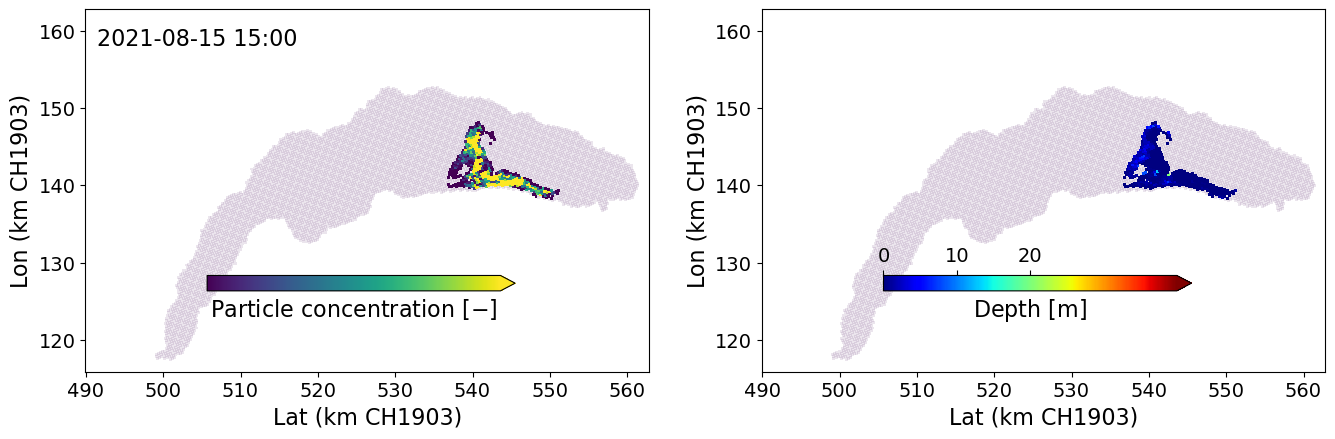

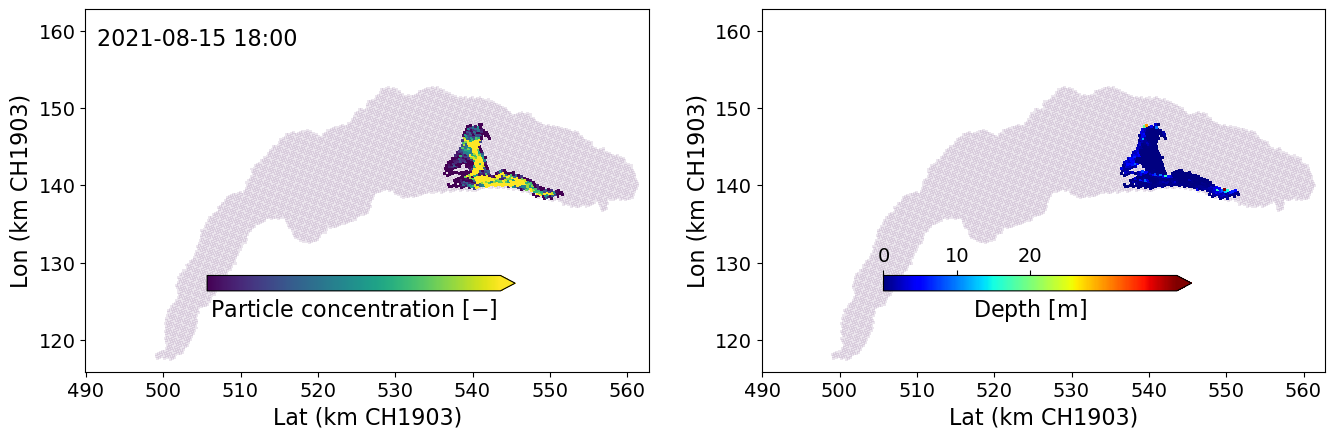

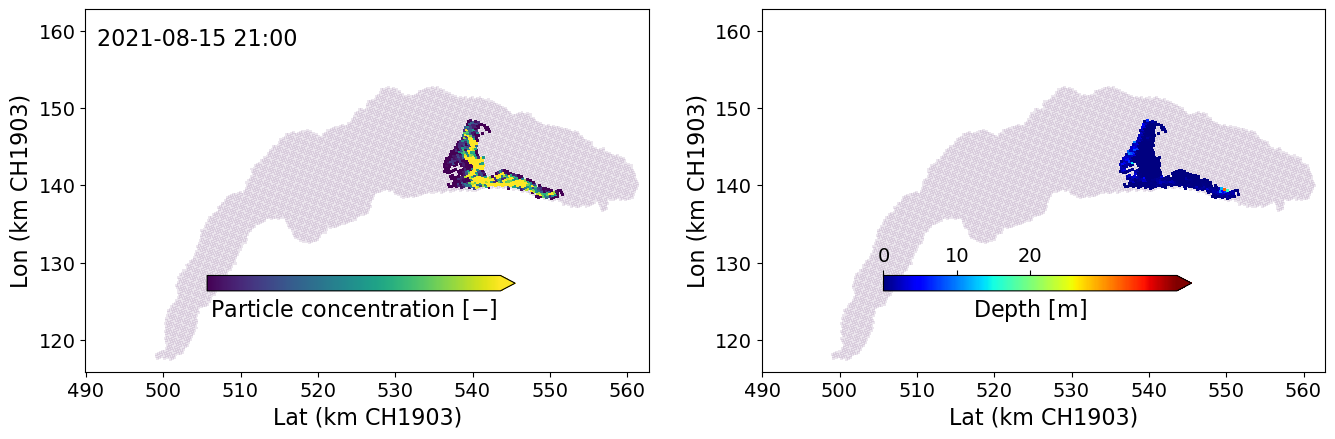

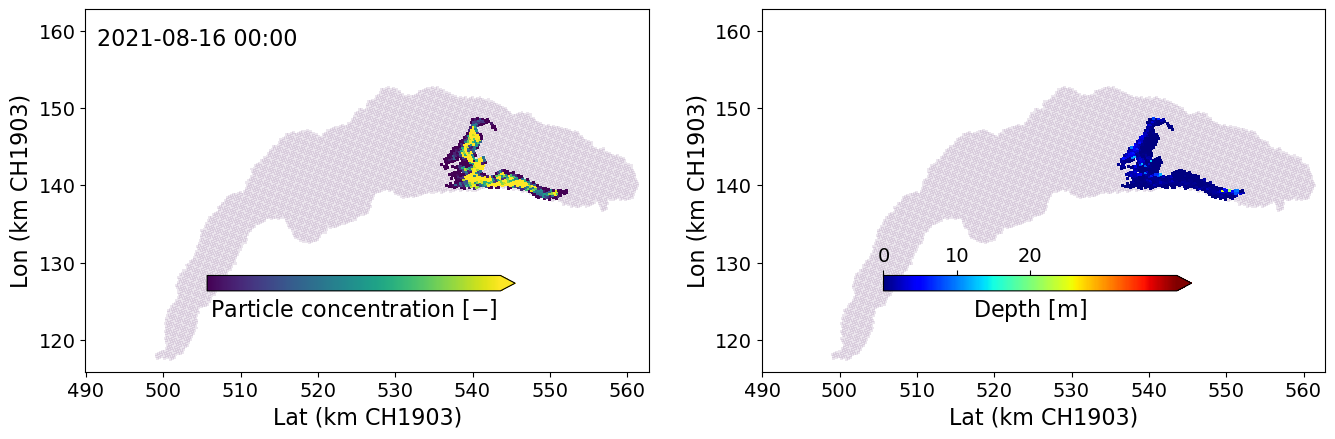

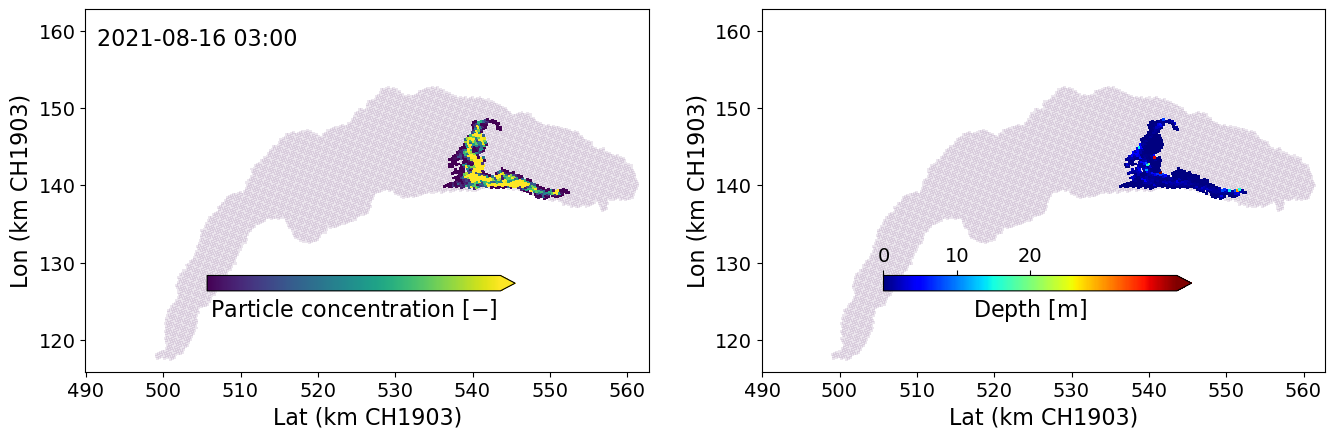

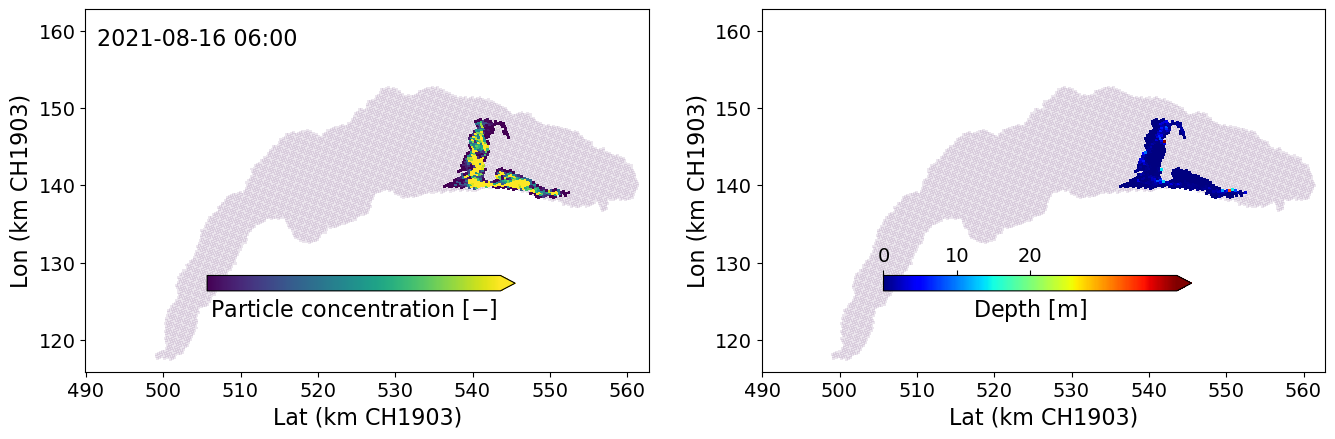

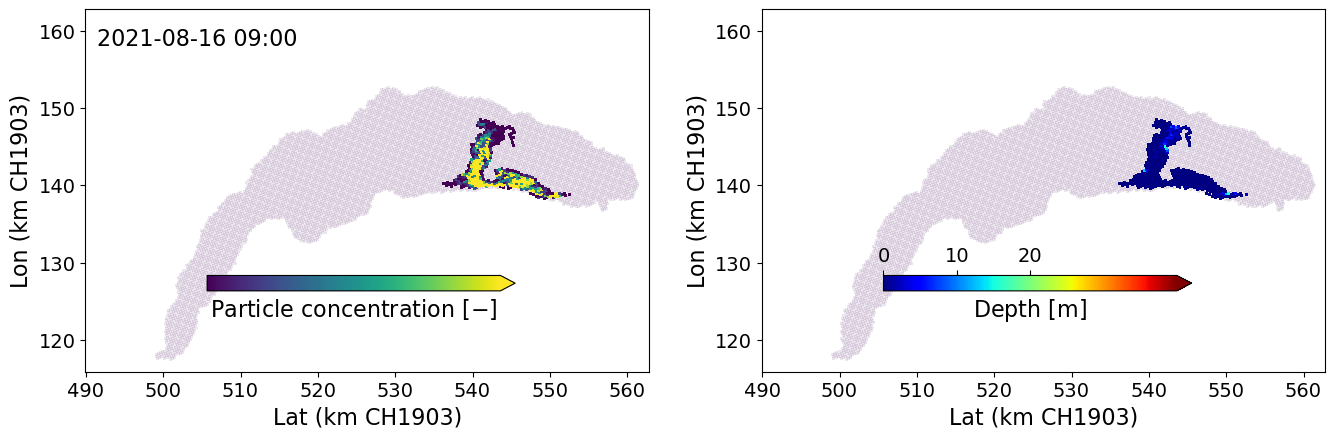

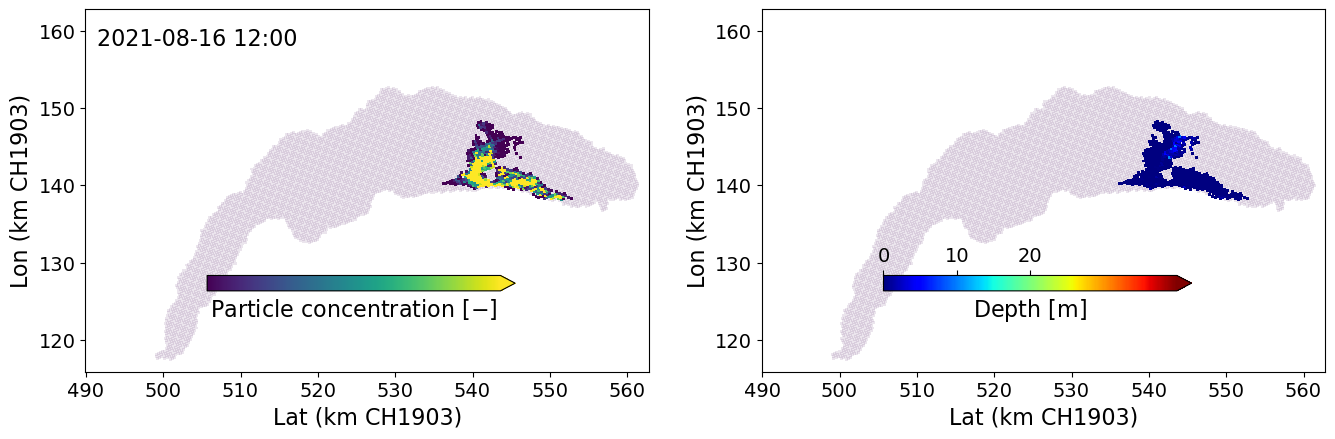

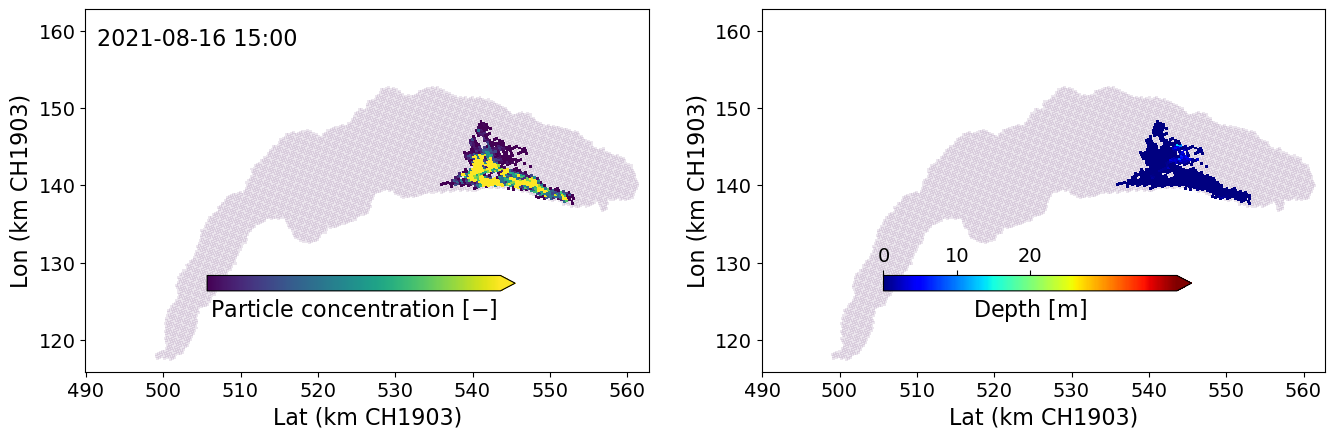

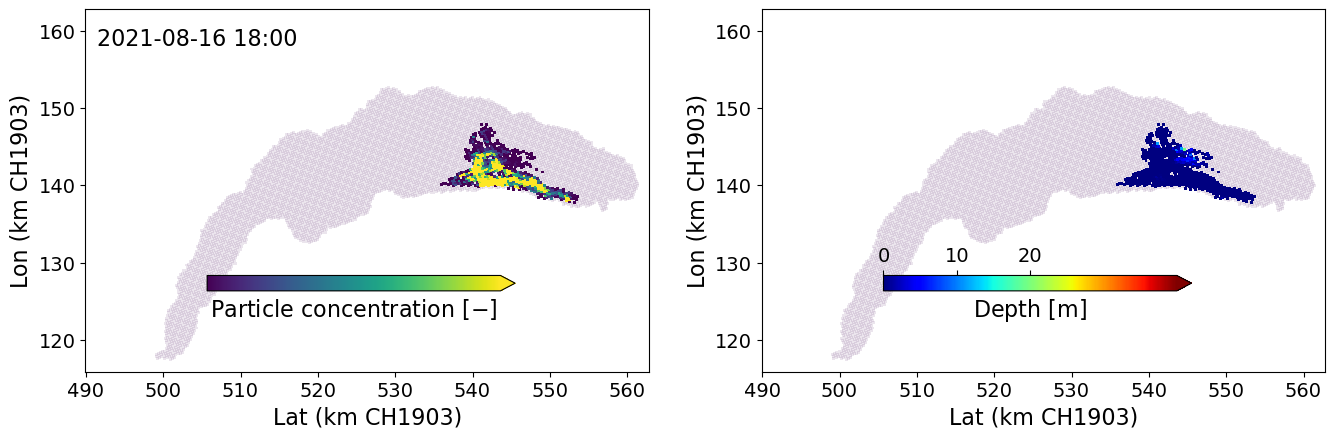

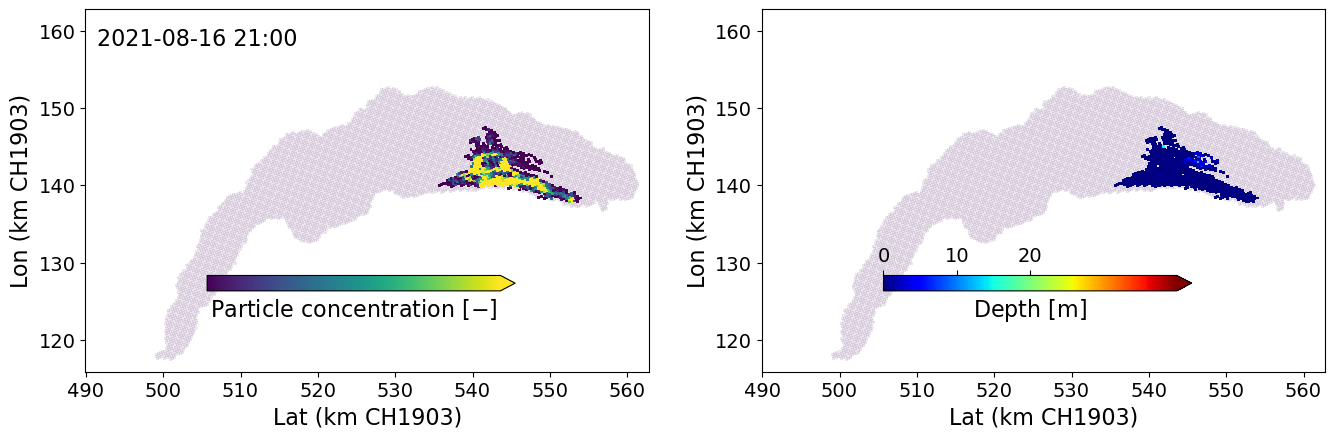

In [76]:
# plot the snapshots of particle tracking results (will be used to make the movie)
# the post-processing can be modifed by assigning a depth-weight function depending on the secchi depth. 
# I implemented it for the Uroglena paper, and we can do it later for all lakes

%matplotlib inline
for qq in range(len(time_plt)):
    # cutoff_date = '2021-09-05T09:30:00.000000000'

    ###############
    for zd in zdata:
        # now = zd.sel(time=np.datetime64(cutoff_date), drop=True)
        now = zd.sel(time=time_plt[qq], drop=True)
        xp = (now.xtrack).to_masked_array().filled()
        xp[xp > 1e9] = np.nan
        yp = now.ytrack.to_masked_array().filled()
        yp[yp > 1e9] = np.nan
        zp = now.ztrack.to_masked_array().filled()
        zp[zp > 450] = np.nan


    ###############   
    part_no_snap, _, _ = np.histogram2d(xp, yp, bins=[xg_plt[0,:],yg_plt[:,0]])
    part_no_snap = part_no_snap.T
    part_no_snap[part_no_snap<2] = np.nan
    min_val = 2 #np.nanquantile(part_no_snap,0.2)
    part_no_snap[part_no_snap<min_val] = np.nan
    # max_val = np.nanquantile(part_no_snap,0.8)
    

    ############### 
    part_depth_snap = part_no_snap.copy()
    part_depth_snap[:,:] = 0

    for ii in range(len(xp)):
        if ((~np.isnan(xp[ii])) & (~np.isnan(yp[ii]))):
            ind_x = np.searchsorted(0.5*(xg_plt[0,:-1]+xg_plt[0,1:]),xp[ii])
            ind_y = np.searchsorted(0.5*(yg_plt[:-1,0]+yg_plt[1:,0]),yp[ii])
            if ((~np.isnan(zp[ii])) & (zp[ii]<5)):
                part_depth_snap[ind_y,ind_x] = part_depth_snap[ind_y,ind_x]+zp[ii]

    part_depth_snap = part_depth_snap/part_no_snap
    # part_depth_snap[part_depth_snap>60] = np.nan
    # part_no_snap[part_depth_snap>10] = np.nan

    fig_size = (16,5)


    f = plt.figure(figsize=fig_size)
    #cmocean.cm.balance
    ax = f.add_subplot(121)
    plt.pcolormesh(xp_conv[:-1,:-1], yp_conv[:-1,:-1],lake_arr,alpha=0.1)
    plt.hold=True
    # SS = plt.pcolormesh(xx_sg,yy_sg,Temp, cmap=cmocean.cm.thermal,shading='flat')
    SS = plt.pcolormesh(xp_conv[:-1,:-1],yp_conv[:-1,:-1],part_no_snap,vmin=np.nanquantile(part_no_snap,0.25), vmax=np.nanquantile(part_no_snap,0.75), cmap='viridis')

    plt.xticks(fontname=font_feature[0],fontsize=font_feature[2])
    plt.yticks(fontname=font_feature[0],fontsize=font_feature[2])

#     ax.set_xlim(497, 565)
#     ax.set_ylim(115, 155)
    ax.set_aspect('equal')
    ax.set_xlabel("Lat (km CH1903)",fontname=font_feature[0],fontsize=font_feature[1])
    ax.set_ylabel("Lon (km CH1903)",fontname=font_feature[0],fontsize=font_feature[1])
    ax.annotate(str(time_plt[qq].values.astype("datetime64[m]")).replace("T", " "),xy=(0.02, 0.9), xycoords='axes fraction',fontname=font_feature[0],fontsize=font_feature[1])

    cbar = plt.colorbar(fraction=0.04,orientation="horizontal",pad=-0.25,extend='max');
    cbar.ax.set_xticklabels([])
    cbar.ax.set_xticks([])
    cbar.set_label(label='$\mathregular{Particle \ concentration\ [-]}$',family=font_feature[0],size=font_feature[1])


    ax2 = f.add_subplot(122)
    plt.pcolormesh(xp_conv[:-1,:-1], yp_conv[:-1,:-1],lake_arr,alpha=0.1)
    plt.hold=True
    # SS = plt.pcolormesh(xx_sg,yy_sg,Temp, cmap=cmocean.cm.thermal,shading='flat')
    SS = plt.pcolormesh(xp_conv[:-1,:-1],yp_conv[:-1,:-1],part_depth_snap, cmap='jet',vmin=0, vmax=40)
    plt.xticks(fontname=font_feature[0],fontsize=font_feature[2])
    plt.yticks(fontname=font_feature[0],fontsize=font_feature[2])

    ax2.set_aspect('equal')
    ax2.set_xlabel("Lat (km CH1903)",fontname=font_feature[0],fontsize=font_feature[1])
    ax2.set_ylabel("Lon (km CH1903)",fontname=font_feature[0],fontsize=font_feature[1])


    cbar2 = plt.colorbar(fraction=0.04,orientation="horizontal",pad=-0.25,extend='max',ticks=[0,10,20]);
    cbar2.ax.set_xticklabels([0,10,20],fontname=font_feature[0],fontsize=font_feature[2])
    cbar2.set_label(label='$\mathregular{Depth\ [m]}$',family=font_feature[0],size=font_feature[1])
    cbar2.ax.xaxis.set_ticks_position('top')

#     plt.savefig(output_path+str(qq).zfill(3)+'_'+str(time_plt[qq].values.astype("datetime64[m]")).replace("T", " ")[0:10]+'H'+str(time_plt[qq].values.astype("datetime64[m]")).replace("T", " ")[11:13]+'.png',dpi=300, bbox_inches = 'tight')

    plt.show()
    plt.close()